In [1]:
import numpy as np
import gymnasium as gym
from matplotlib import pyplot as plt
from collections import deque
import random
import pandas as pd
import torch

# DQN

In [8]:
class DQlearn:
    
    def __init__(self, 
                 alpha,
                 gamma,
                 layers, 
                 memory=1000):
        self.env = gym.make('CartPole-v1')
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = 1
        self.min_epsilon = 0.01
        self.decr_epsilon = 0.99
        self.model = self.get_model(layers)
        self.memory = deque(maxlen=memory)
        self.opt = torch.optim.Adam(self.model.parameters(), lr=self.alpha)
        self.loss = torch.nn.MSELoss()
        
    def get_model(self, layers):
        model = torch.nn.Sequential(*layers)
        return model

    def act(self, states):
        if np.random.random() > self.epsilon:
            return np.argmax(self.model(torch.FloatTensor(states)).detach().numpy())
        return np.random.randint(2)
    
    def train(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for states, action, reward, done, new_states in minibatch:
            label = reward
            if not done:
                new_states = torch.FloatTensor(new_states)
                label += self.gamma * torch.max(self.model(new_states))
            states = torch.FloatTensor(states)
            flabel = self.model(states).detach().numpy()
            flabel[0][action] = label
            flabel = torch.FloatTensor(flabel)
            self.opt.zero_grad()
            out = self.model(states)
            self.loss(out, flabel).backward()
            self.opt.step()
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.decr_epsilon
    
    def run(self, max_run, batch_size):
        rewards = []
        n=0
        while n < max_run:
            states = self.env.reset()[0].reshape((1,4))
            done = False
            step = 0
            rew = 0
            while step < 200:
                action = self.act(states)
                obs, r, term, trunc, info= self.env.step(action)

                done = term or trunc
                
                self.memory.append((states, action, r, done, obs))
                states = obs.reshape((1,4))
                rew += r
                step += 1
                if done:
                    break
            rewards.append(rew)
            n += 1
            print(f'Episode: {n}, reward: {rew}')
            if len(self.memory) > batch_size:
                self.train(batch_size)
        return rewards

## First fit

In [9]:
dql_test = DQlearn(0.001, 0.95, [torch.nn.Linear(4, 64), 
                                 torch.nn.ReLU(),
                                 torch.nn.Linear(64, 32), 
                                 torch.nn.ReLU(), 
                                 torch.nn.Linear(32, 2)])
rewards_dql = dql_test.run(1000, 64)

Episode: 1, reward: 17.0
Episode: 2, reward: 31.0
Episode: 3, reward: 16.0
Episode: 4, reward: 23.0
Episode: 5, reward: 41.0
Episode: 6, reward: 22.0
Episode: 7, reward: 36.0
Episode: 8, reward: 16.0
Episode: 9, reward: 11.0
Episode: 10, reward: 15.0
Episode: 11, reward: 21.0
Episode: 12, reward: 12.0
Episode: 13, reward: 18.0
Episode: 14, reward: 18.0
Episode: 15, reward: 40.0
Episode: 16, reward: 17.0
Episode: 17, reward: 36.0
Episode: 18, reward: 24.0
Episode: 19, reward: 39.0
Episode: 20, reward: 13.0
Episode: 21, reward: 23.0
Episode: 22, reward: 11.0
Episode: 23, reward: 14.0
Episode: 24, reward: 11.0
Episode: 25, reward: 11.0
Episode: 26, reward: 18.0
Episode: 27, reward: 12.0
Episode: 28, reward: 21.0
Episode: 29, reward: 16.0
Episode: 30, reward: 16.0
Episode: 31, reward: 15.0
Episode: 32, reward: 18.0
Episode: 33, reward: 14.0
Episode: 34, reward: 16.0
Episode: 35, reward: 13.0
Episode: 36, reward: 14.0
Episode: 37, reward: 8.0
Episode: 38, reward: 18.0
Episode: 39, reward: 1

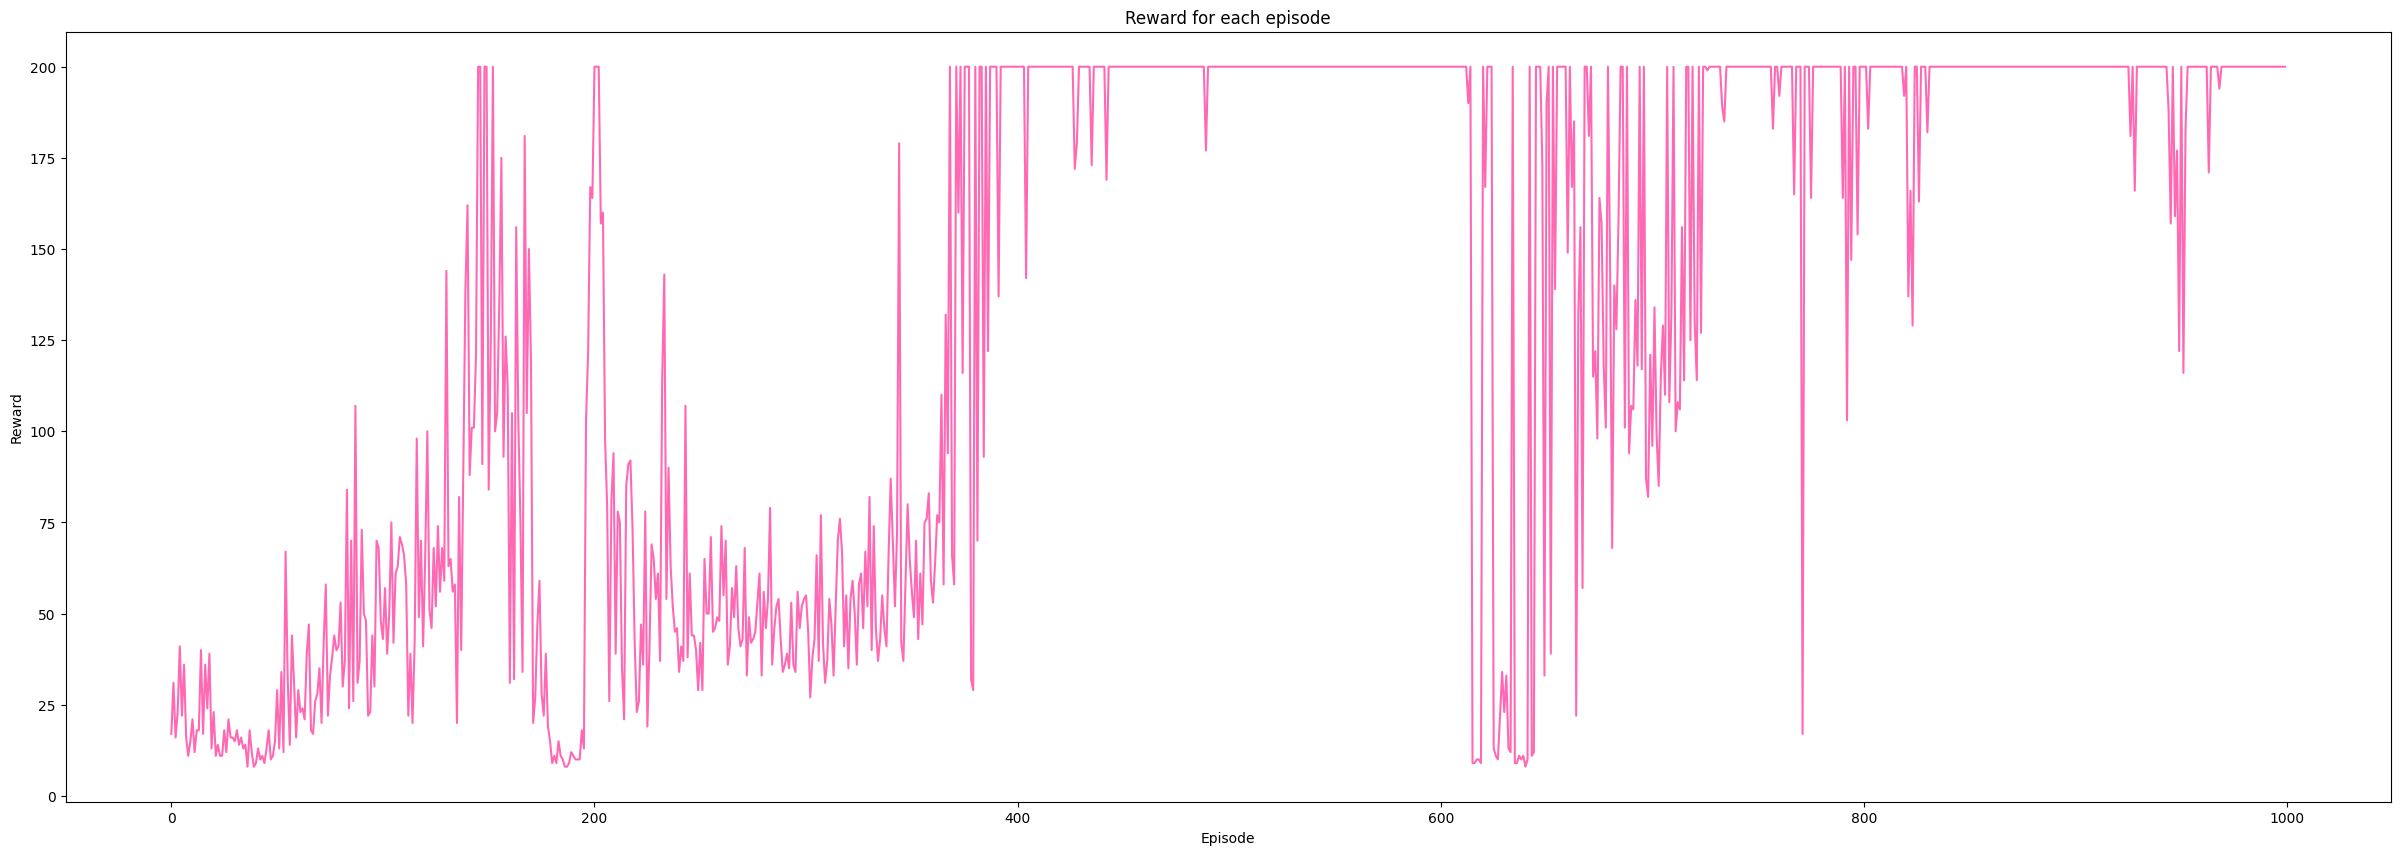

In [10]:
figure = plt.figure(figsize=(30,10))
plt.plot(rewards_dql, color='hotpink')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward for each episode')
plt.show()

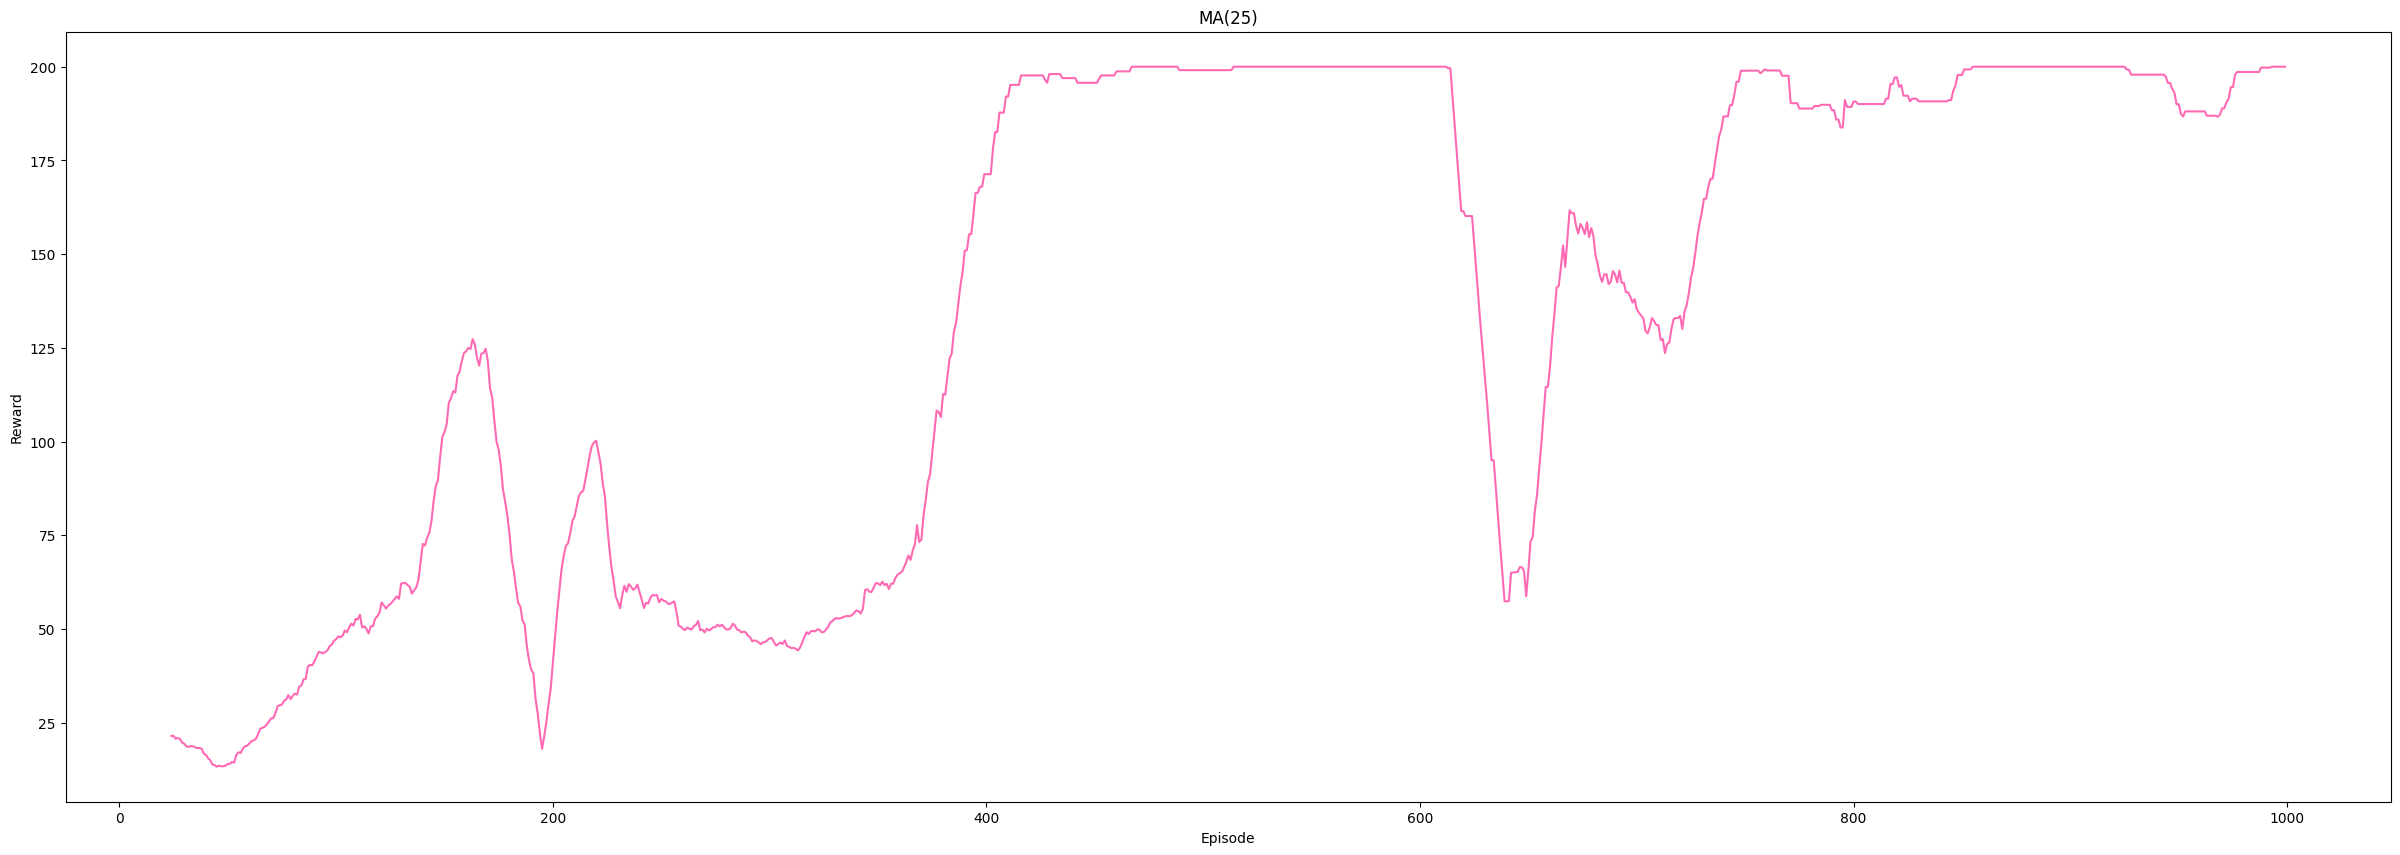

In [11]:
figure = plt.figure(figsize=(30,10))
plt.plot(pd.Series(rewards_dql).rolling(25).mean(), color='hotpink')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('MA(25)')
plt.show()

In [46]:
def get_first_200(rewards):
    time_200 = np.where(np.asarray(rewards)==200)[0]
    if len(time_200) > 0:
        time_200 = time_200[0]
    return time_200

In [47]:
print(f'For the first model, 200 at time: {get_first_200(rewards_dql)}')

For the first model, 200 at time: 145


Test number of layers

In [12]:
rewards_lay = np.zeros((4,1000))
layers = [torch.nn.Linear(4, 64), torch.nn.ReLU(64), torch.nn.Linear(64, 2)]
for i in range(4):
    dqn_temp = DQlearn(0.001, 0.95, layers)
    rewards_lay[i, :] = dqn_temp.run(1000, 64)
    layers.pop()
    layers.extend([torch.nn.Linear(64, 64),
                   torch.nn.ReLU(64), 
                   torch.nn.Linear(64, 2)])

Episode: 1, reward: 20.0
Episode: 2, reward: 19.0
Episode: 3, reward: 15.0
Episode: 4, reward: 14.0
Episode: 5, reward: 27.0
Episode: 6, reward: 23.0
Episode: 7, reward: 13.0
Episode: 8, reward: 16.0
Episode: 9, reward: 13.0
Episode: 10, reward: 21.0
Episode: 11, reward: 10.0
Episode: 12, reward: 13.0
Episode: 13, reward: 13.0
Episode: 14, reward: 12.0
Episode: 15, reward: 20.0
Episode: 16, reward: 14.0
Episode: 17, reward: 20.0
Episode: 18, reward: 12.0
Episode: 19, reward: 10.0
Episode: 20, reward: 10.0
Episode: 21, reward: 31.0
Episode: 22, reward: 17.0
Episode: 23, reward: 11.0
Episode: 24, reward: 12.0
Episode: 25, reward: 9.0
Episode: 26, reward: 53.0
Episode: 27, reward: 13.0
Episode: 28, reward: 18.0
Episode: 29, reward: 9.0
Episode: 30, reward: 11.0
Episode: 31, reward: 19.0
Episode: 32, reward: 26.0
Episode: 33, reward: 39.0
Episode: 34, reward: 22.0
Episode: 35, reward: 18.0
Episode: 36, reward: 34.0
Episode: 37, reward: 10.0
Episode: 38, reward: 48.0
Episode: 39, reward: 11

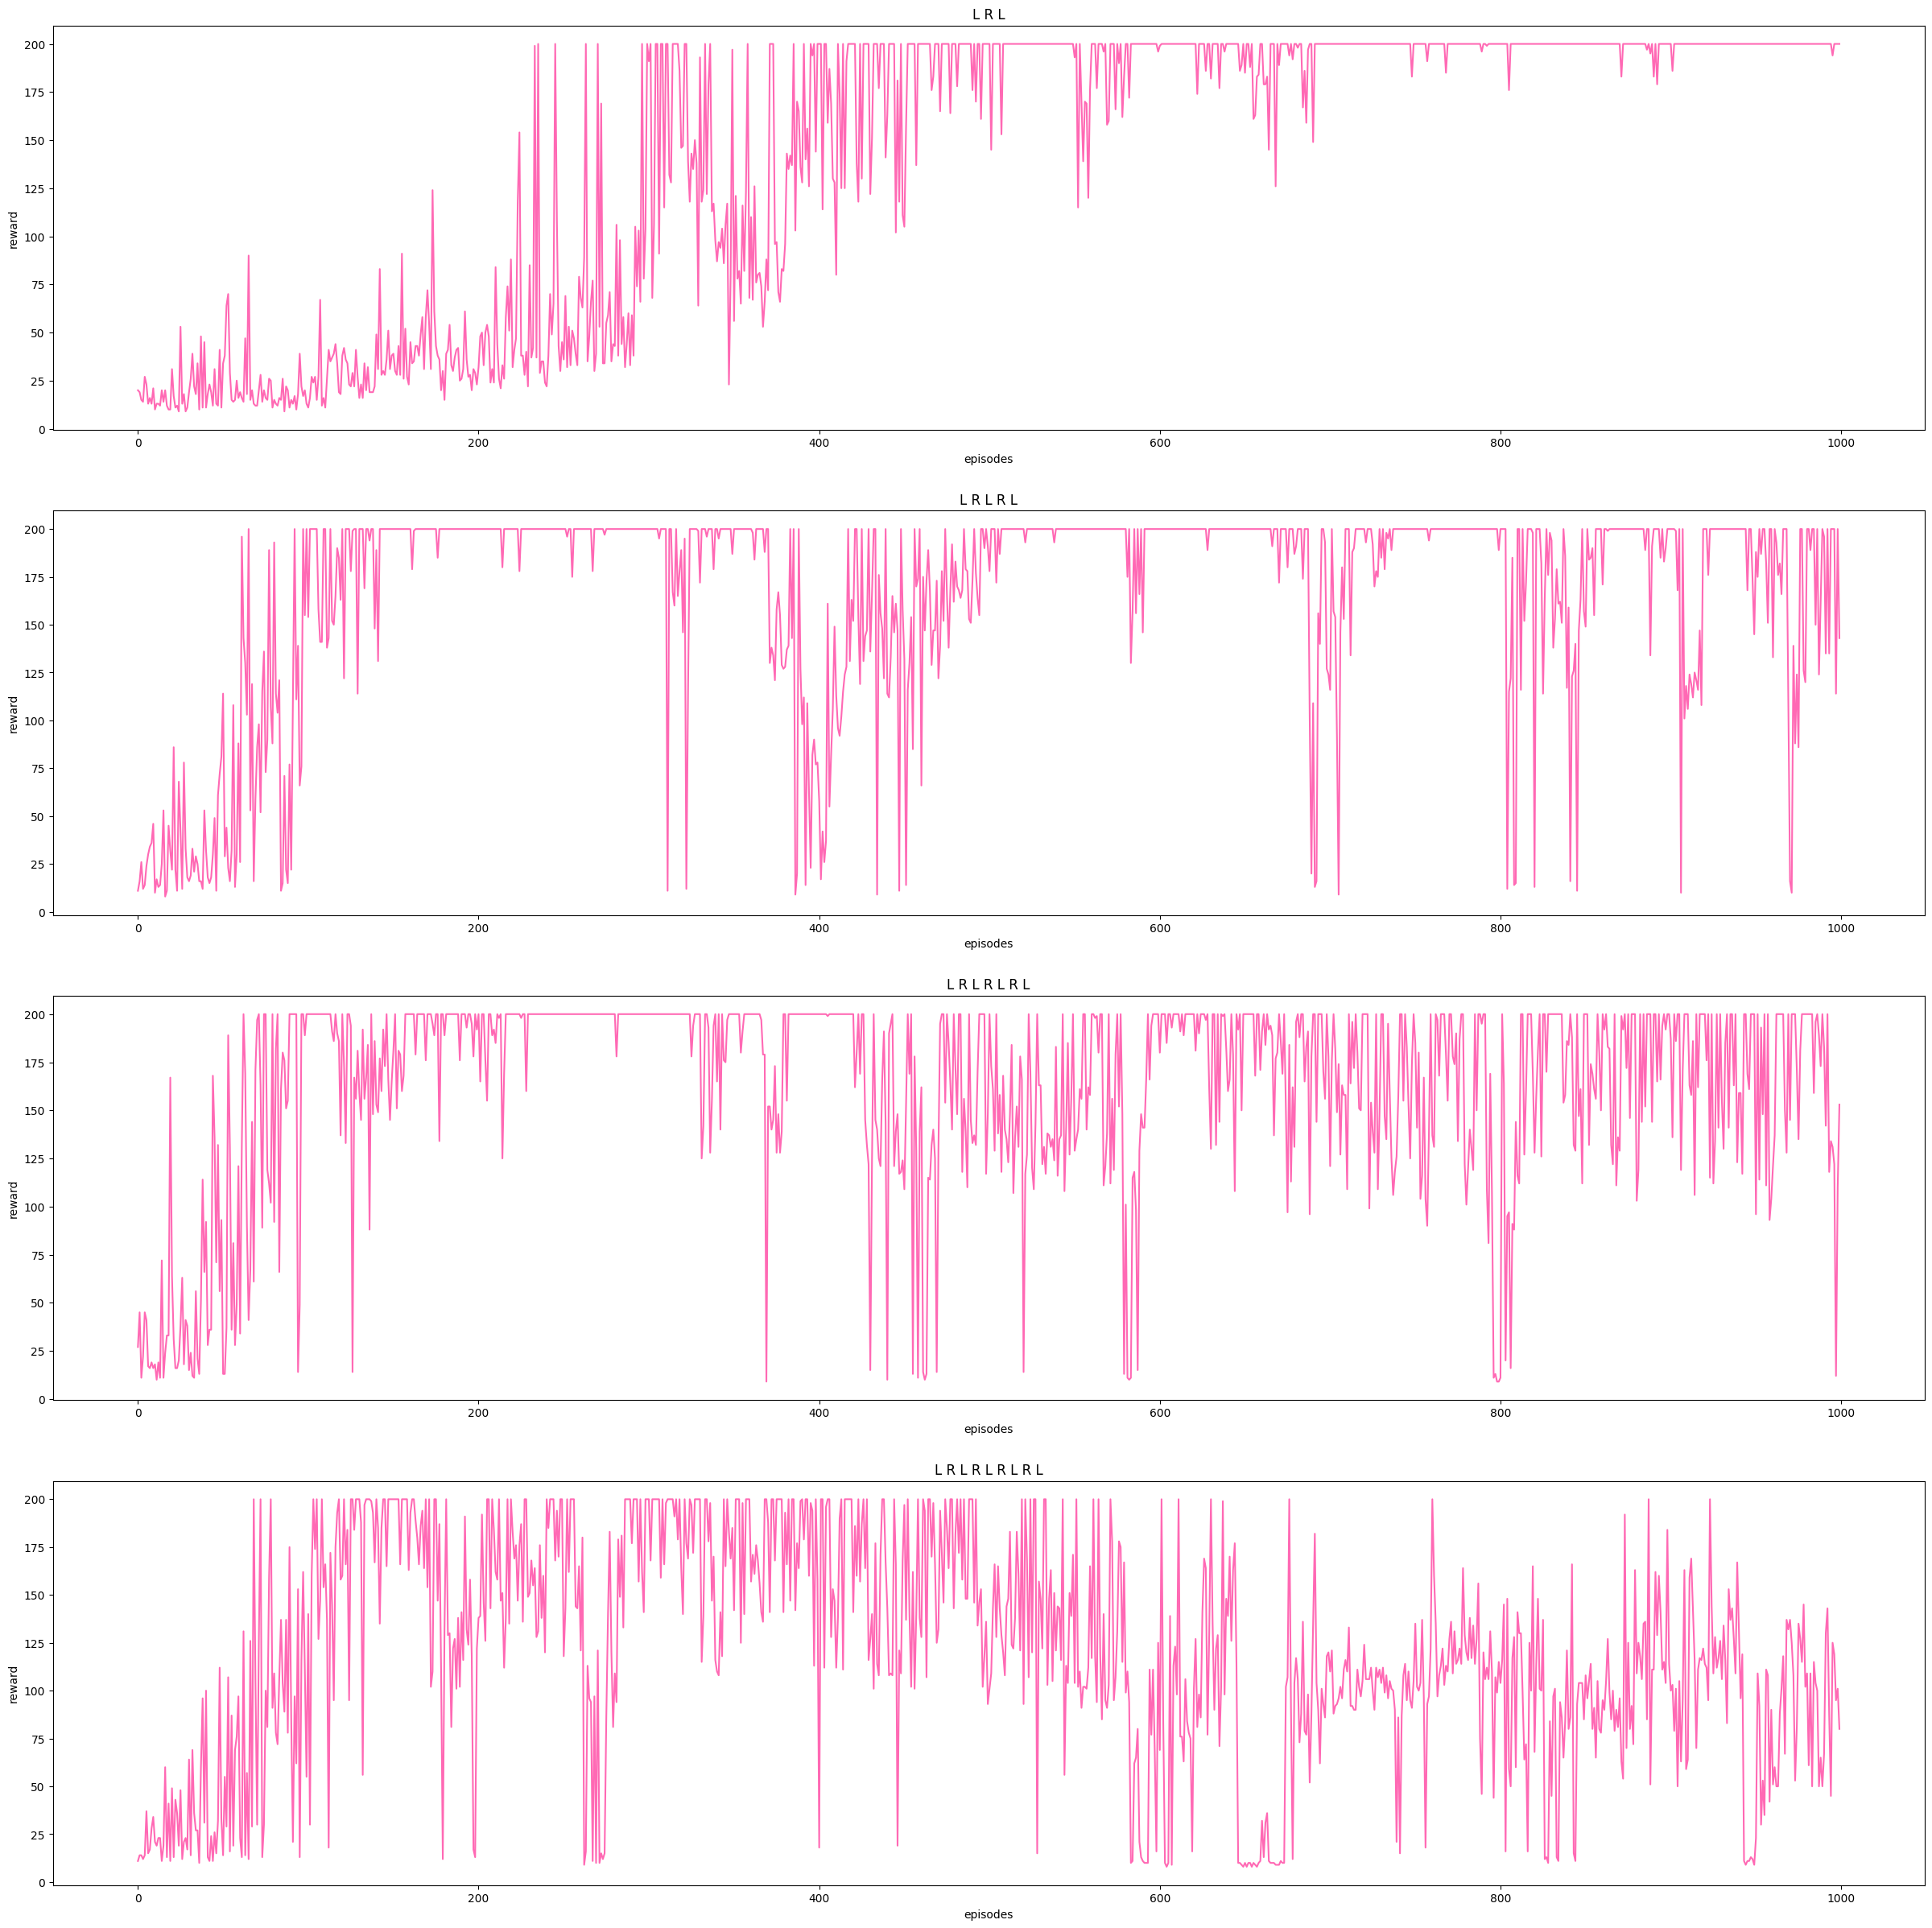

In [13]:
names = ['L R L', 'L R L R L', 'L R L R L R L', 'L R L R L R L R L']
fig, axes = plt.subplots(4, 1, figsize=(30,30))
for i in range(4):
    axes[i].plot(rewards_lay[i], label=names[i], color='hotpink')
    axes[i].set_xlabel('episodes')
    axes[i].set_ylabel('reward')
    axes[i].set_title(names[i])
plt.show()

In [49]:
for i in range(4):
    print(f'For the {names[i]} model, 200 at time: {get_first_200(rewards_lay[i,:])}')

For the L R L model, 200 at time: 235
For the L R L R L model, 200 at time: 65
For the L R L R L R L model, 200 at time: 62
For the L R L R L R L R L model, 200 at time: 68


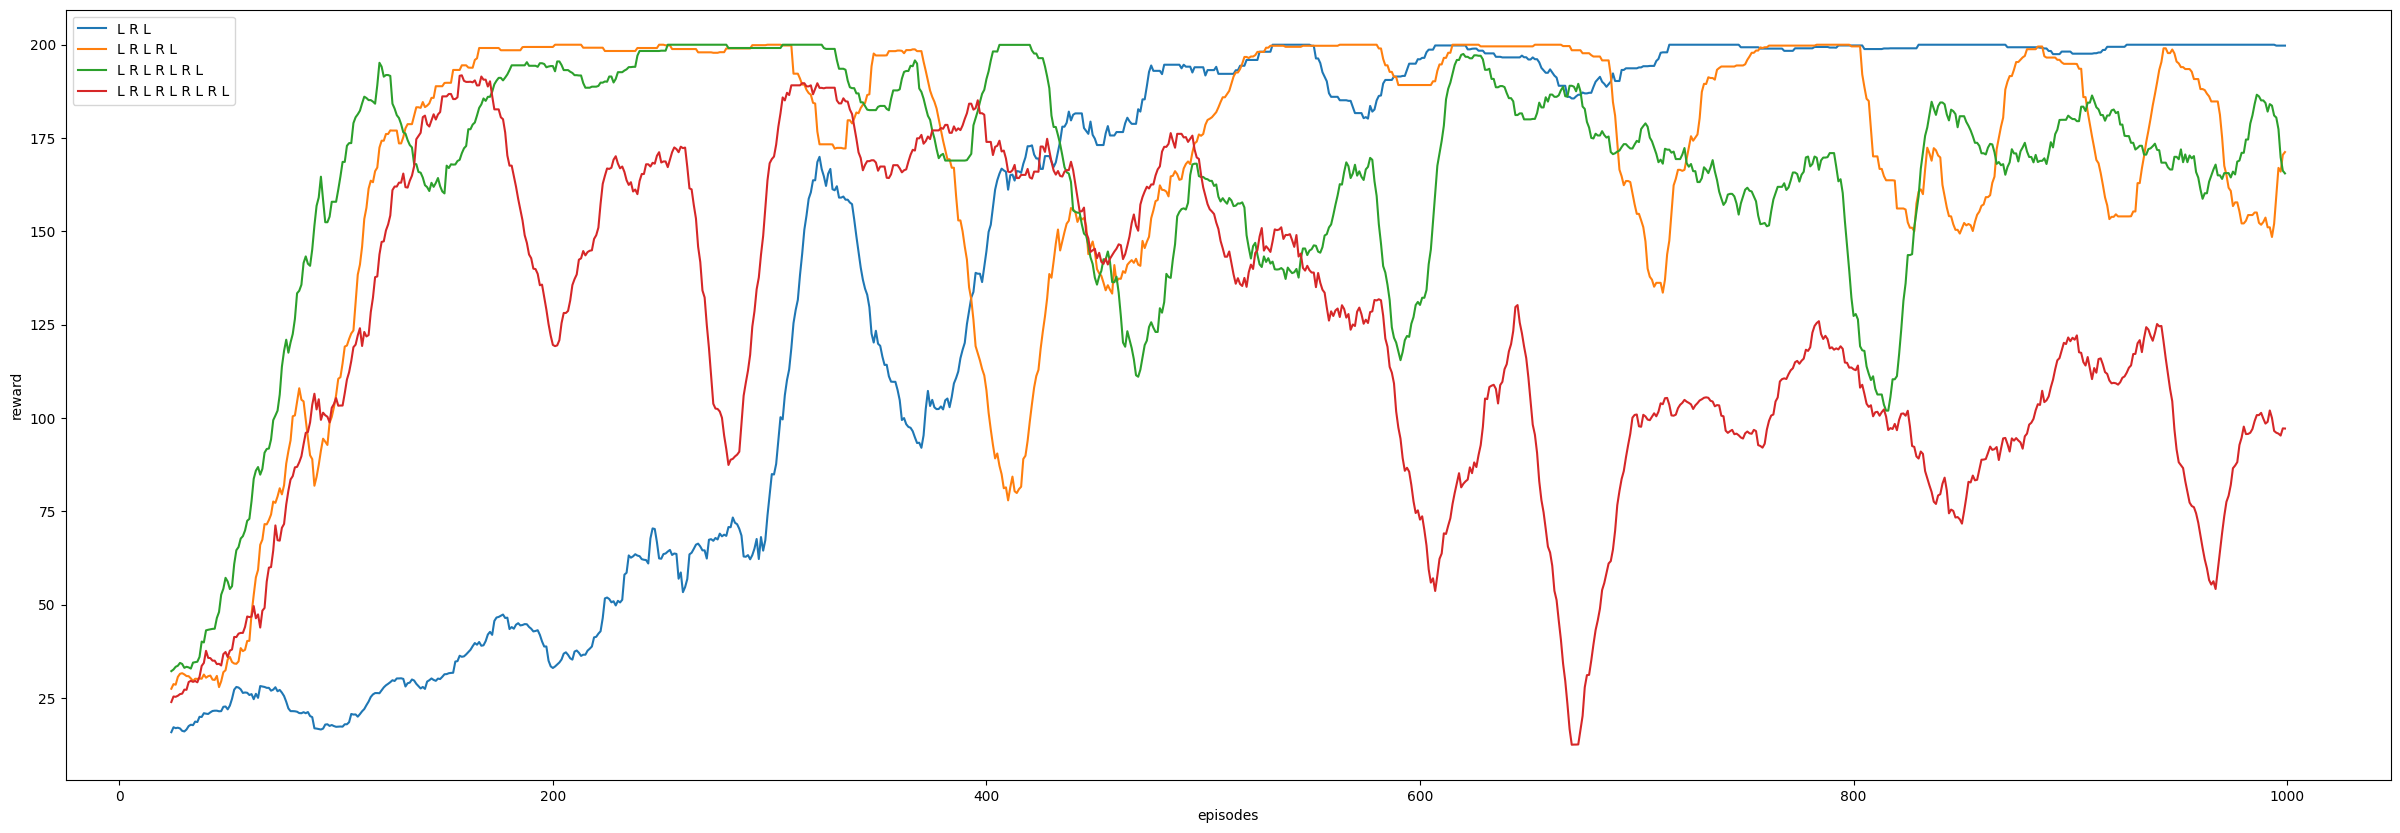

In [15]:
fig = plt.figure(figsize=(30,10))
for i in range(4):
    plt.plot(pd.Series(rewards_lay[i]).rolling(25).mean(), label=names[i])
plt.xlabel('episodes')
plt.ylabel('reward')
plt.legend()
plt.show()

Change discount

In [16]:
rewards_disc = np.zeros((5,1000))
layers = [torch.nn.Linear(4, 64), torch.nn.ReLU(), torch.nn.Linear(64, 2)]
discount = [0.95, 0.96, 0.97, 0.98, 0.99]
for i in range(5):
    dqn_temp = DQlearn(0.001, discount[i], layers)
    rewards_disc[i, :] = dqn_temp.run(1000, 64)

Episode: 1, reward: 21.0
Episode: 2, reward: 11.0
Episode: 3, reward: 26.0
Episode: 4, reward: 16.0
Episode: 5, reward: 19.0
Episode: 6, reward: 27.0
Episode: 7, reward: 11.0
Episode: 8, reward: 45.0
Episode: 9, reward: 18.0
Episode: 10, reward: 20.0
Episode: 11, reward: 57.0
Episode: 12, reward: 15.0
Episode: 13, reward: 26.0
Episode: 14, reward: 23.0
Episode: 15, reward: 9.0
Episode: 16, reward: 27.0
Episode: 17, reward: 16.0
Episode: 18, reward: 19.0
Episode: 19, reward: 24.0
Episode: 20, reward: 10.0
Episode: 21, reward: 21.0
Episode: 22, reward: 18.0
Episode: 23, reward: 34.0
Episode: 24, reward: 19.0
Episode: 25, reward: 19.0
Episode: 26, reward: 45.0
Episode: 27, reward: 19.0
Episode: 28, reward: 32.0
Episode: 29, reward: 14.0
Episode: 30, reward: 108.0
Episode: 31, reward: 19.0
Episode: 32, reward: 12.0
Episode: 33, reward: 28.0
Episode: 34, reward: 26.0
Episode: 35, reward: 32.0
Episode: 36, reward: 21.0
Episode: 37, reward: 30.0
Episode: 38, reward: 51.0
Episode: 39, reward: 

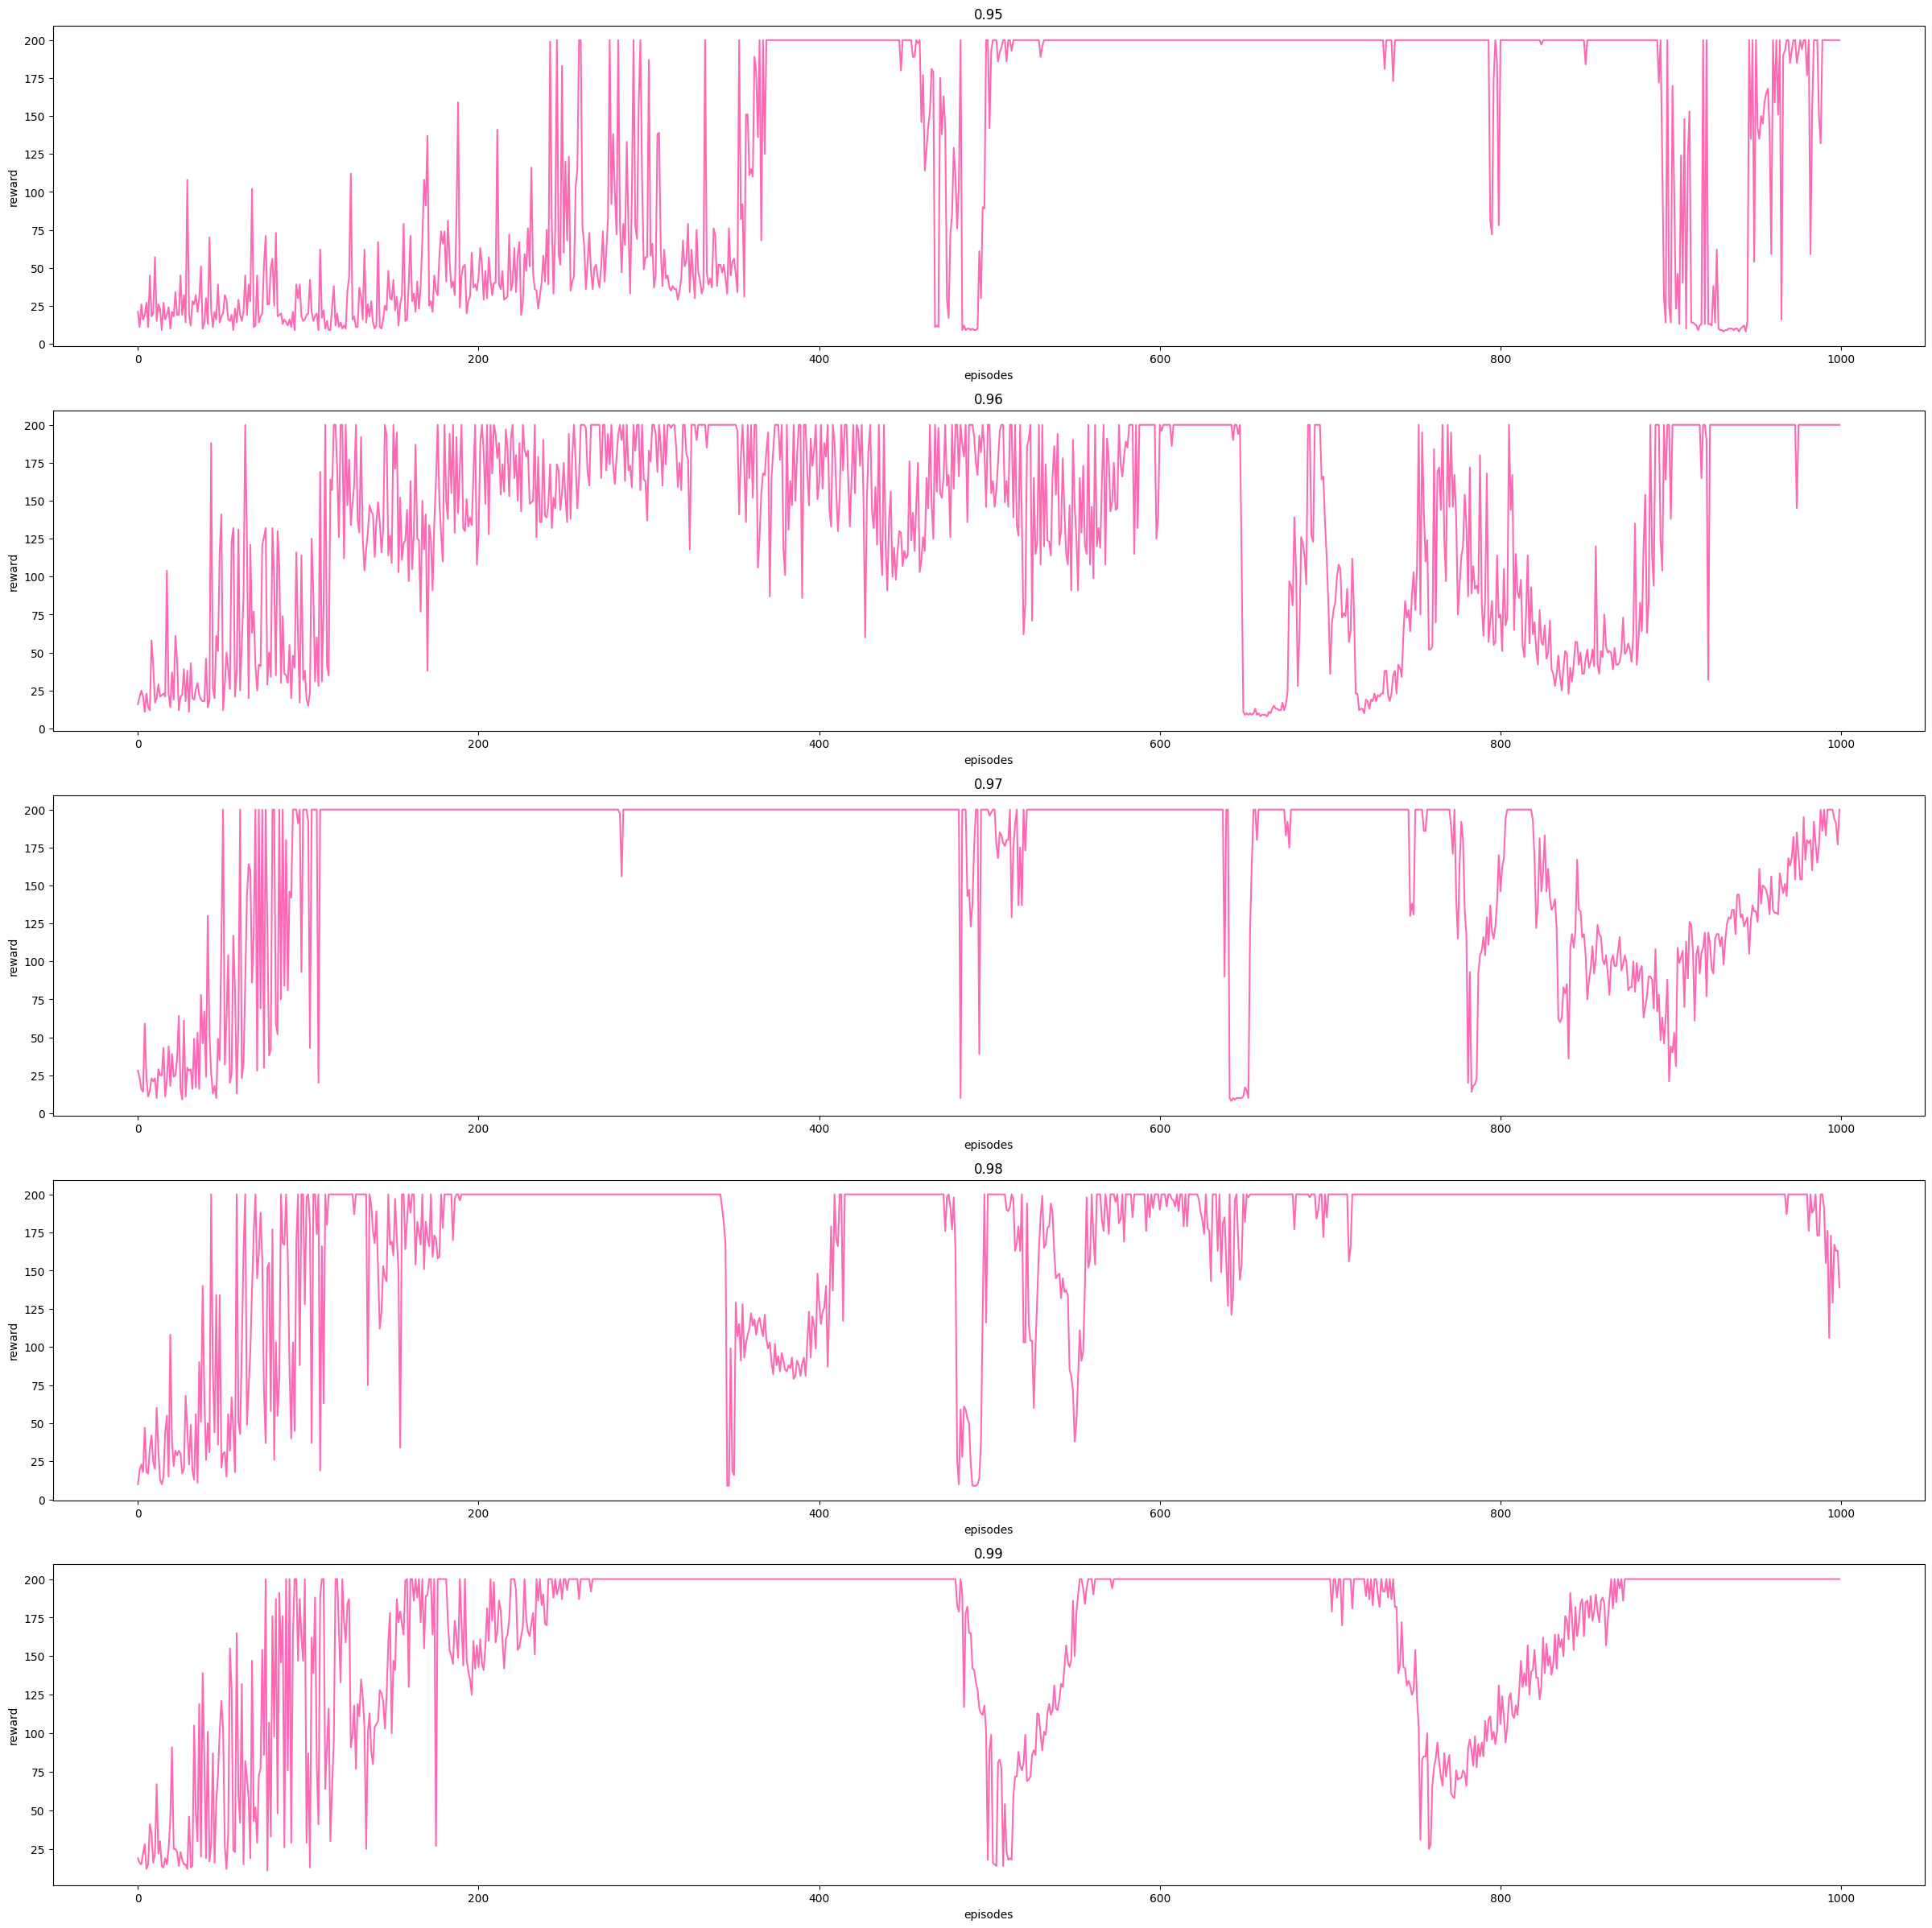

In [17]:
fig, axes = plt.subplots(5, 1, figsize=(30,30))
for i in range(5):
    axes[i].plot(rewards_disc[i], color = 'hotpink')
    axes[i].set_xlabel('episodes')
    axes[i].set_ylabel('reward')
    axes[i].set_title(str(discount[i]))
plt.show()

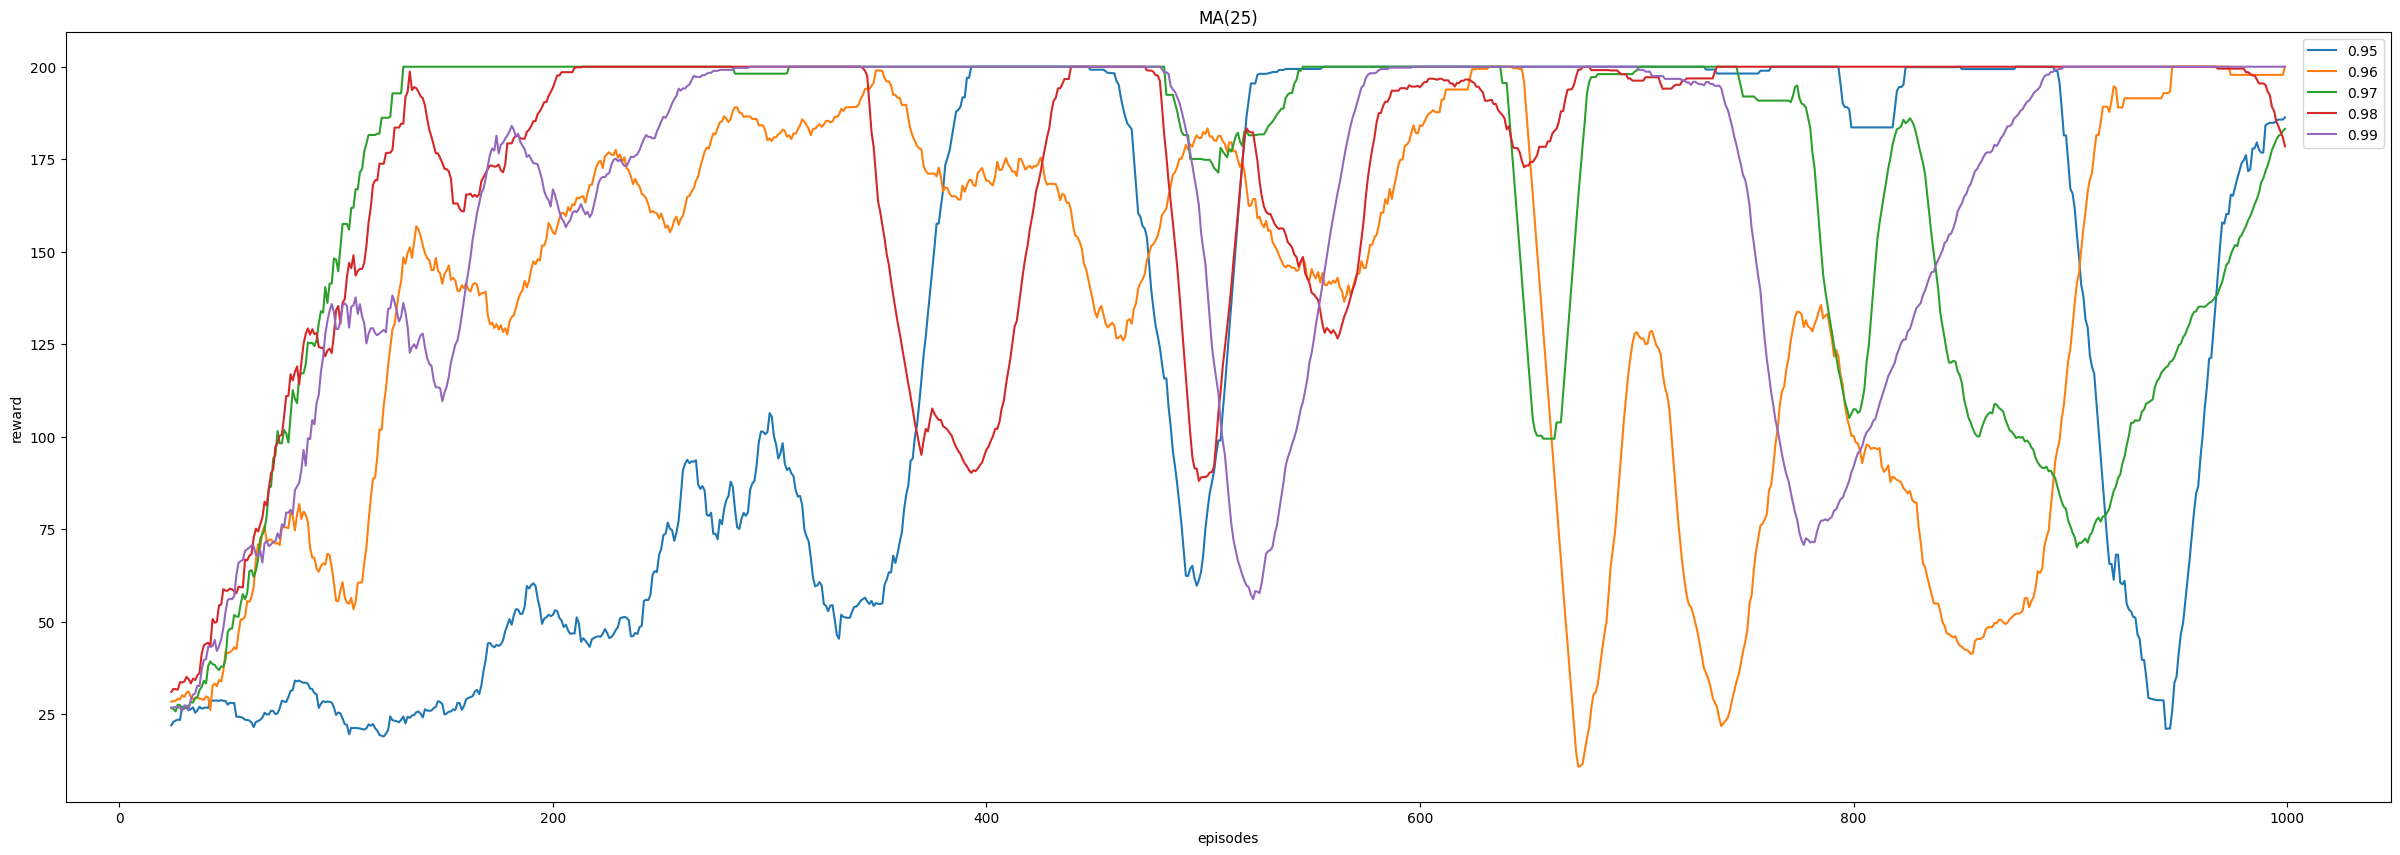

In [31]:
fig = plt.figure(figsize=(30,10))
for i in range(5):
    plt.plot(pd.Series(rewards_disc[i]).rolling(25).mean(), label = str(discount[i]))
plt.xlabel('episodes')
plt.ylabel('reward')
plt.title('MA(25)')
plt.legend()
plt.show()

In [50]:
for i in range(5):
    print(f'For the {discount[i]} model, 200 at time: {get_first_200(rewards_disc[i,:])}')

For the 0.95 model, 200 at time: 246
For the 0.96 model, 200 at time: 63
For the 0.97 model, 200 at time: 50
For the 0.98 model, 200 at time: 43
For the 0.99 model, 200 at time: 75


## Check learning rate

In [20]:
rewards_lr = np.zeros((5,1000))
layers = [torch.nn.Linear(4, 64), torch.nn.ReLU(), torch.nn.Linear(64, 2)]
lrs = [0.0001, 0.001, 0.01, 0.1, 1]
for i in range(5):
    dqn_temp = DQlearn(lrs[i], 0.95, layers)
    rewards_lr[i, :] = dqn_temp.run(1000, 64)

Episode: 1, reward: 17.0
Episode: 2, reward: 24.0
Episode: 3, reward: 28.0
Episode: 4, reward: 56.0
Episode: 5, reward: 8.0
Episode: 6, reward: 12.0
Episode: 7, reward: 40.0
Episode: 8, reward: 50.0
Episode: 9, reward: 10.0
Episode: 10, reward: 21.0
Episode: 11, reward: 38.0
Episode: 12, reward: 22.0
Episode: 13, reward: 24.0
Episode: 14, reward: 17.0
Episode: 15, reward: 61.0
Episode: 16, reward: 20.0
Episode: 17, reward: 10.0
Episode: 18, reward: 16.0
Episode: 19, reward: 16.0
Episode: 20, reward: 24.0
Episode: 21, reward: 19.0
Episode: 22, reward: 51.0
Episode: 23, reward: 29.0
Episode: 24, reward: 33.0
Episode: 25, reward: 16.0
Episode: 26, reward: 15.0
Episode: 27, reward: 15.0
Episode: 28, reward: 80.0
Episode: 29, reward: 14.0
Episode: 30, reward: 49.0
Episode: 31, reward: 10.0
Episode: 32, reward: 16.0
Episode: 33, reward: 15.0
Episode: 34, reward: 24.0
Episode: 35, reward: 48.0
Episode: 36, reward: 29.0
Episode: 37, reward: 19.0
Episode: 38, reward: 35.0
Episode: 39, reward: 8

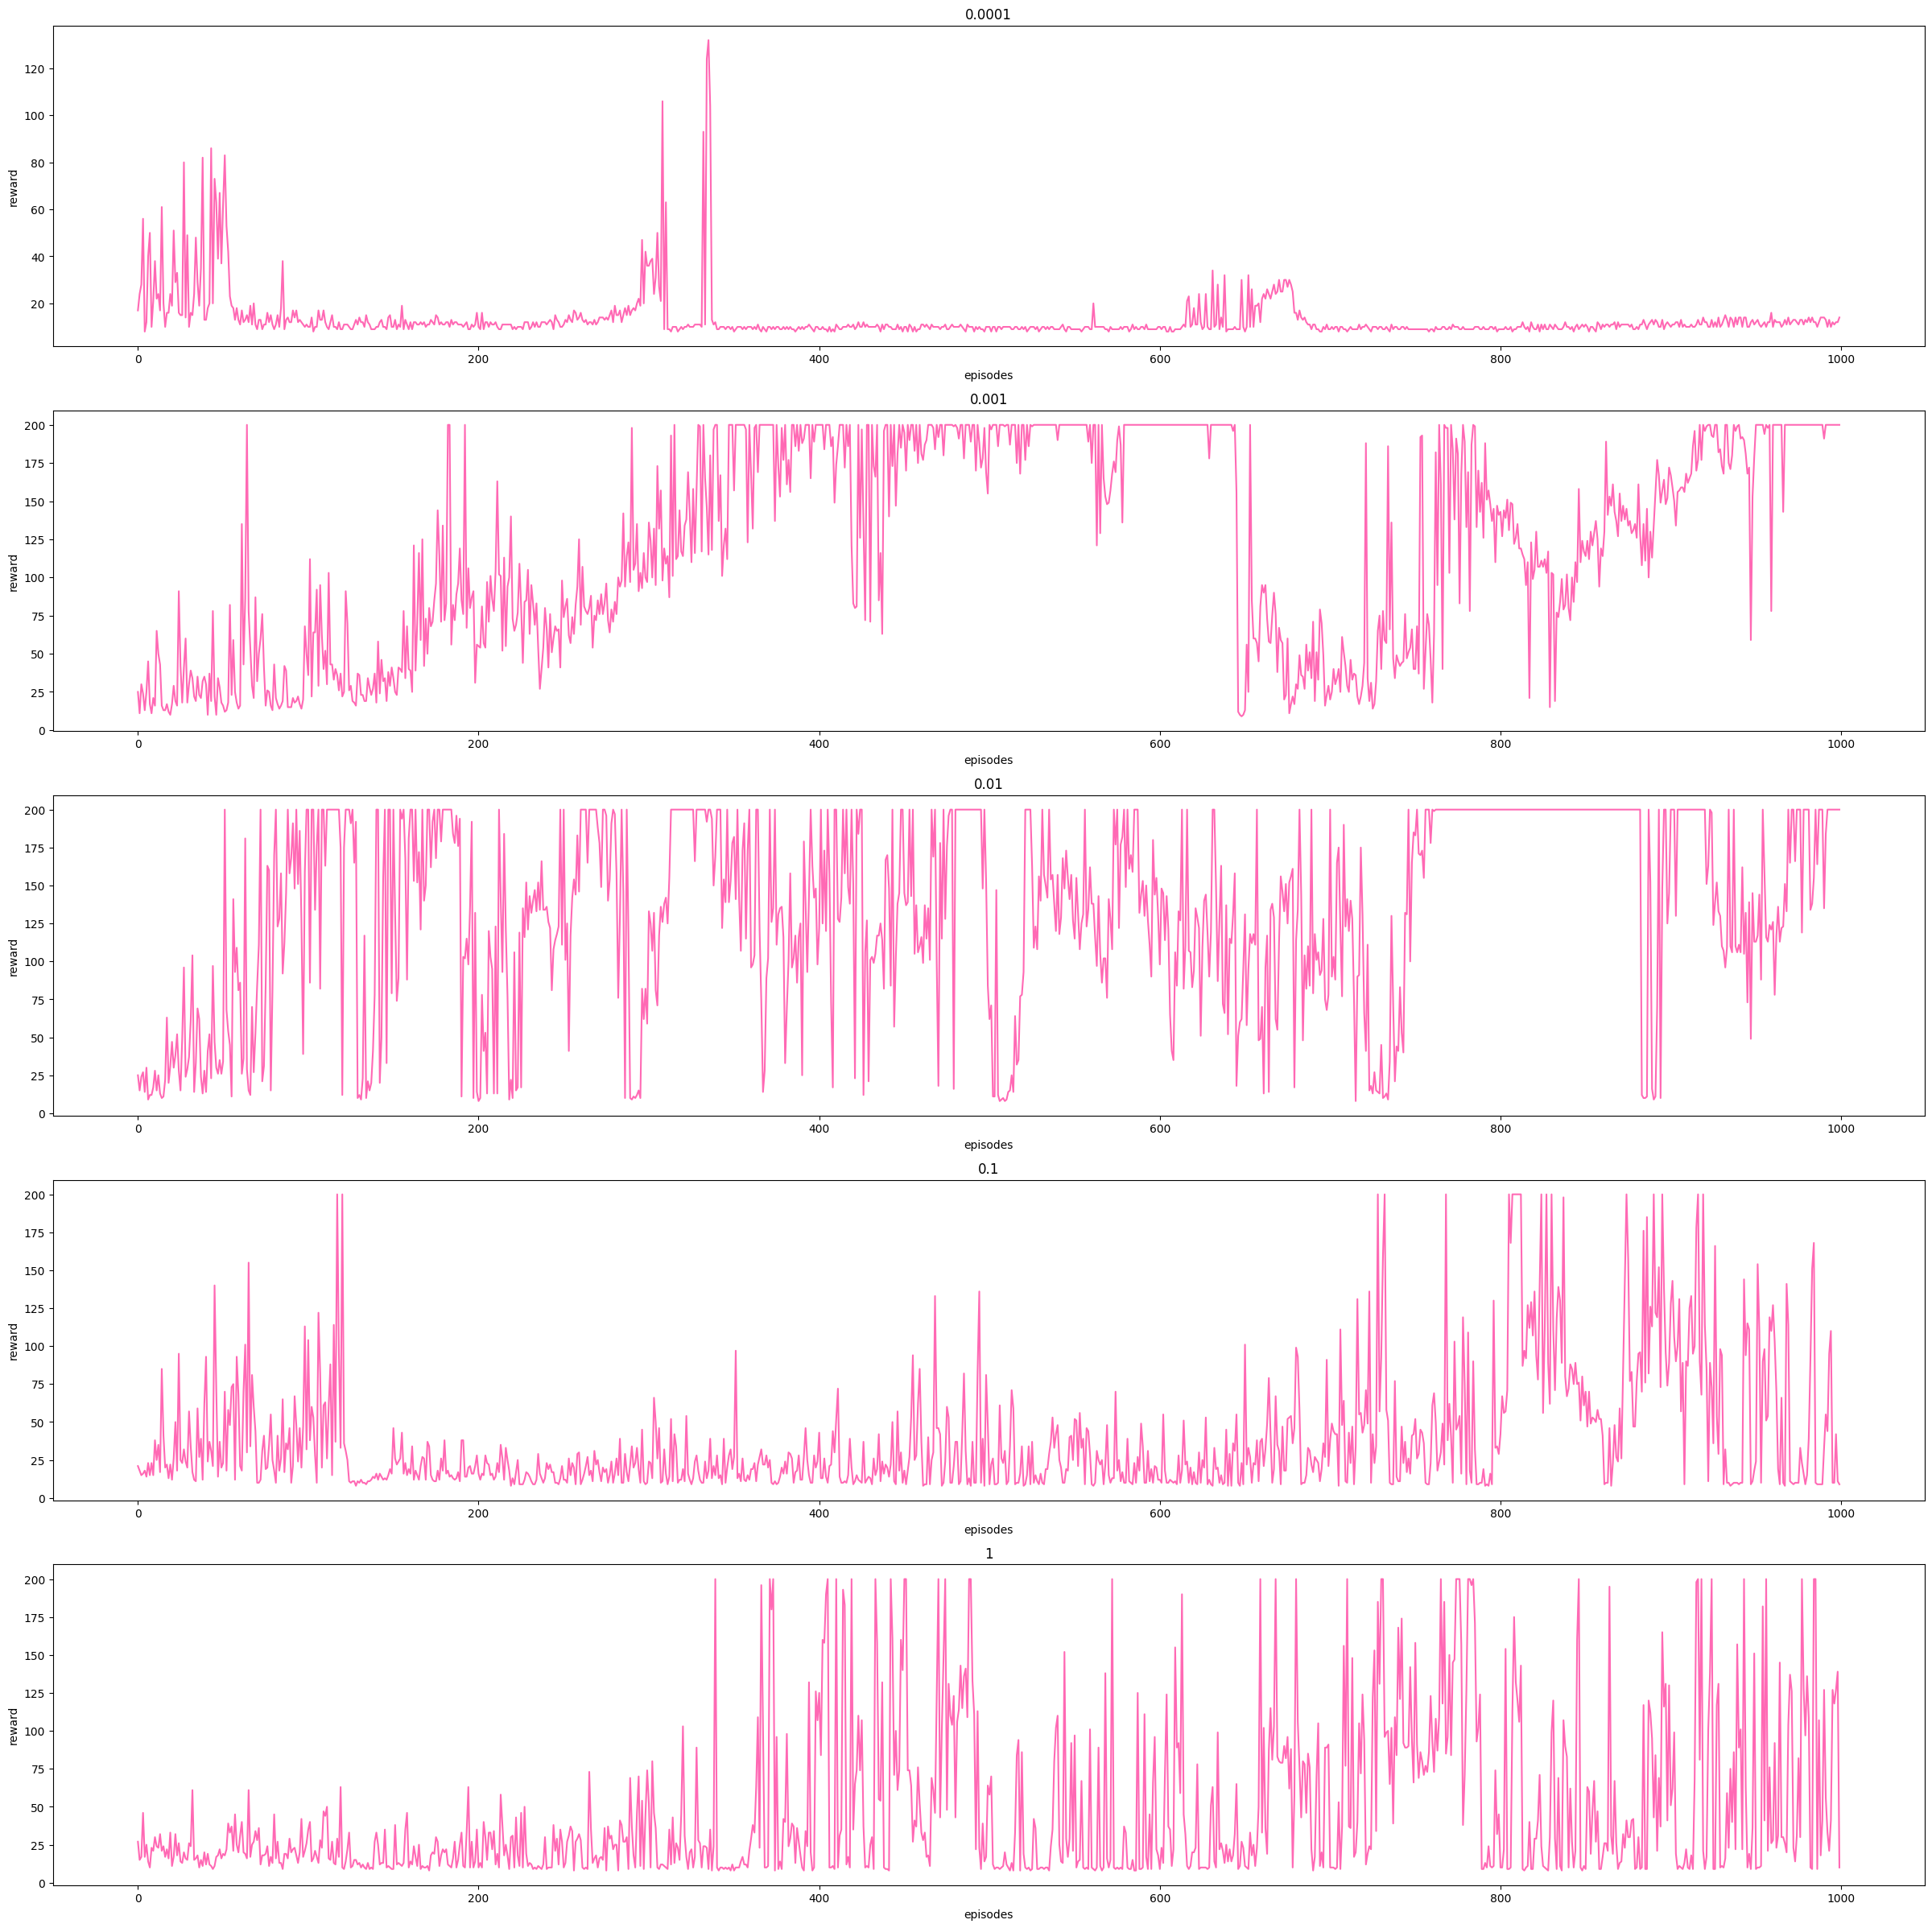

In [22]:
fig, axes = plt.subplots(5, 1, figsize=(30,30))
for i in range(5):
    axes[i].plot(rewards_lr[i], color = 'hotpink')
    axes[i].set_xlabel('episodes')
    axes[i].set_ylabel('reward')
    axes[i].set_title(str(lrs[i]))
plt.show()

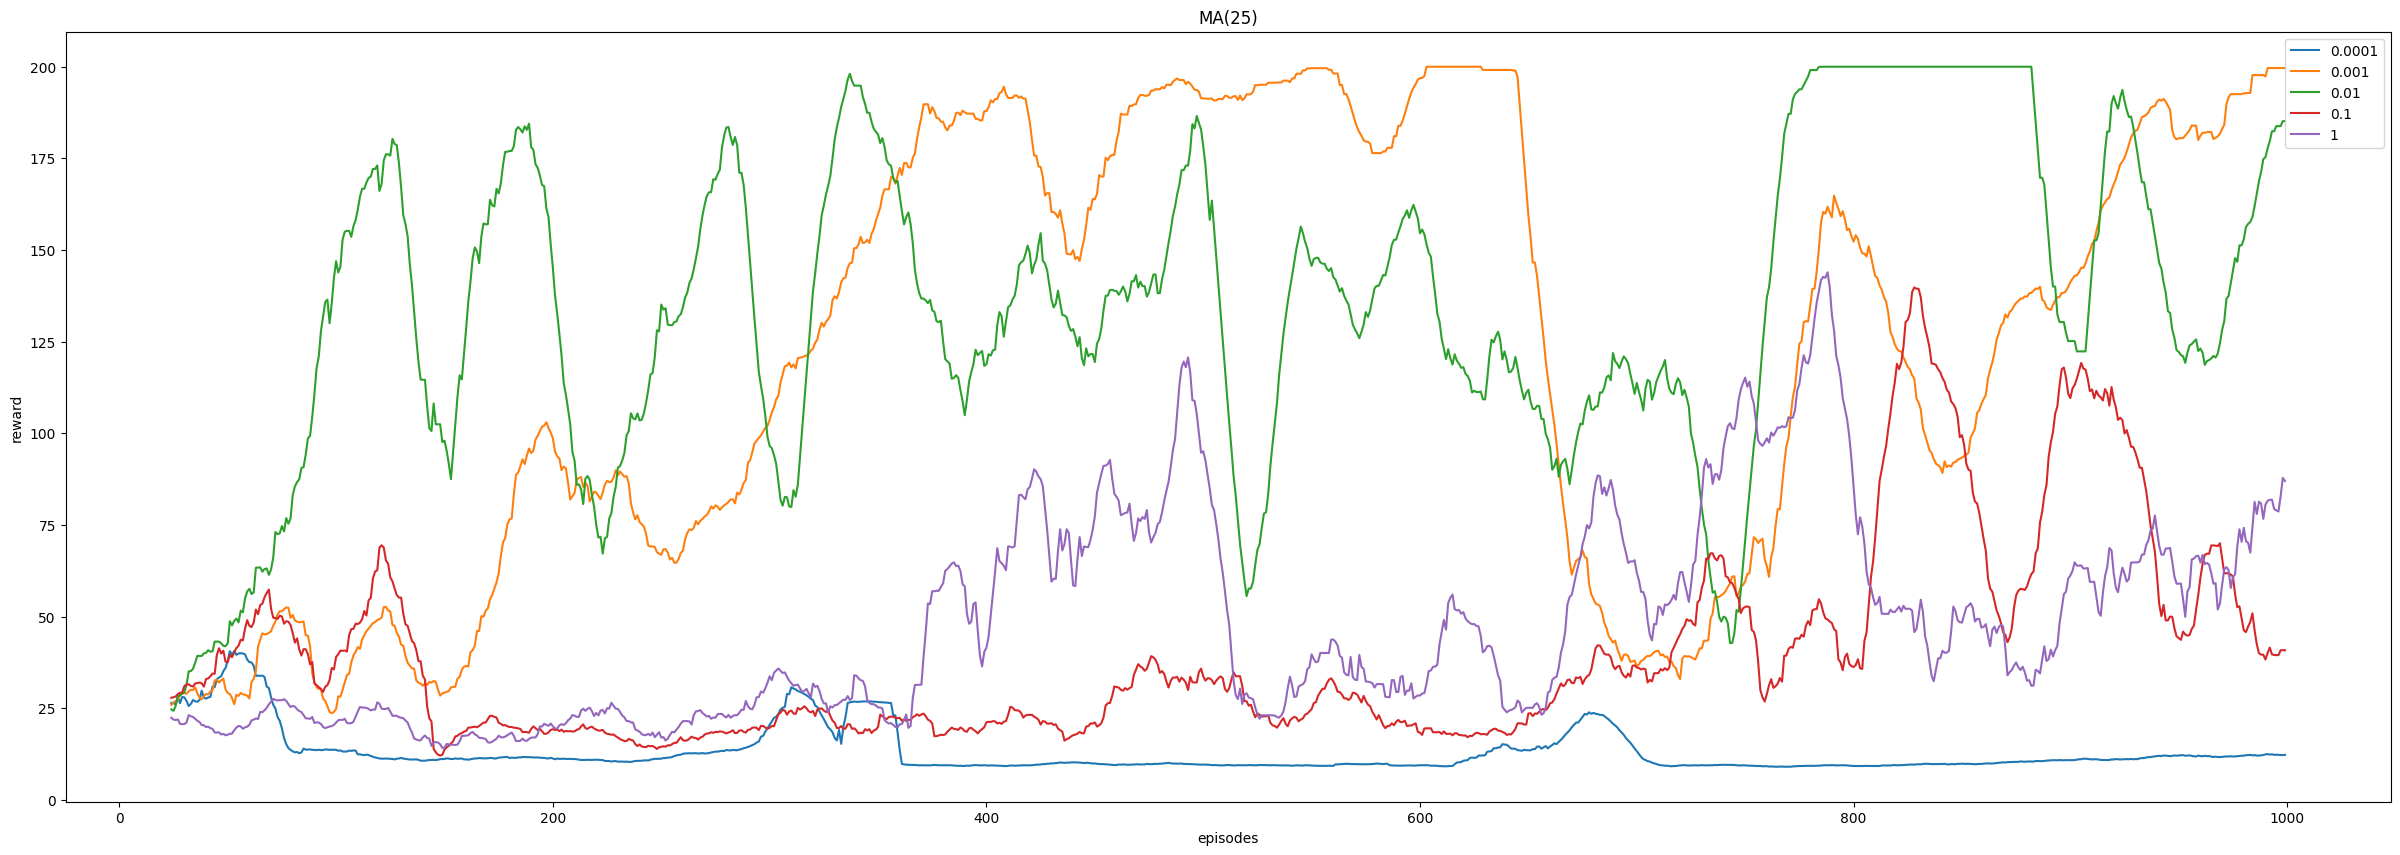

In [30]:
fig = plt.figure(figsize=(30,10))
for i in range(5):
    plt.plot(pd.Series(rewards_lr[i]).rolling(25).mean(), label = str(lrs[i]))
plt.xlabel('episodes')
plt.ylabel('reward')
plt.title('MA(25)')
plt.legend()
plt.show()

In [51]:
for i in range(5):
    print(f'For the {lrs[i]} model, 200 at time: {get_first_200(rewards_lr[i,:])}')

For the 0.0001 model, 200 at time: []
For the 0.001 model, 200 at time: 64
For the 0.01 model, 200 at time: 51
For the 0.1 model, 200 at time: 117
For the 1 model, 200 at time: 339


### Increasing memory size and model complexity to show catastrophic forgetting

In [32]:
layers = [torch.nn.Linear(4, 64), 
          torch.nn.ReLU(), 
          torch.nn.Linear(64, 64), 
          torch.nn.ReLU(), 
          torch.nn.Linear(64, 64), 
          torch.nn.ReLU(), 
          torch.nn.Linear(64, 2)]
dqn_temp = DQlearn(0.001, 0.99, layers, memory=2000)
rewards_disc_temp = dqn_temp.run(1000, 64)

Episode: 1, reward: 17.0
Episode: 2, reward: 19.0
Episode: 3, reward: 48.0
Episode: 4, reward: 9.0
Episode: 5, reward: 53.0
Episode: 6, reward: 14.0
Episode: 7, reward: 13.0
Episode: 8, reward: 24.0
Episode: 9, reward: 17.0
Episode: 10, reward: 20.0
Episode: 11, reward: 9.0
Episode: 12, reward: 28.0
Episode: 13, reward: 15.0
Episode: 14, reward: 29.0
Episode: 15, reward: 21.0
Episode: 16, reward: 12.0
Episode: 17, reward: 14.0
Episode: 18, reward: 19.0
Episode: 19, reward: 15.0
Episode: 20, reward: 12.0
Episode: 21, reward: 13.0
Episode: 22, reward: 33.0
Episode: 23, reward: 10.0
Episode: 24, reward: 12.0
Episode: 25, reward: 14.0
Episode: 26, reward: 12.0
Episode: 27, reward: 17.0
Episode: 28, reward: 13.0
Episode: 29, reward: 14.0
Episode: 30, reward: 10.0
Episode: 31, reward: 13.0
Episode: 32, reward: 23.0
Episode: 33, reward: 18.0
Episode: 34, reward: 19.0
Episode: 35, reward: 12.0
Episode: 36, reward: 19.0
Episode: 37, reward: 10.0
Episode: 38, reward: 9.0
Episode: 39, reward: 25.

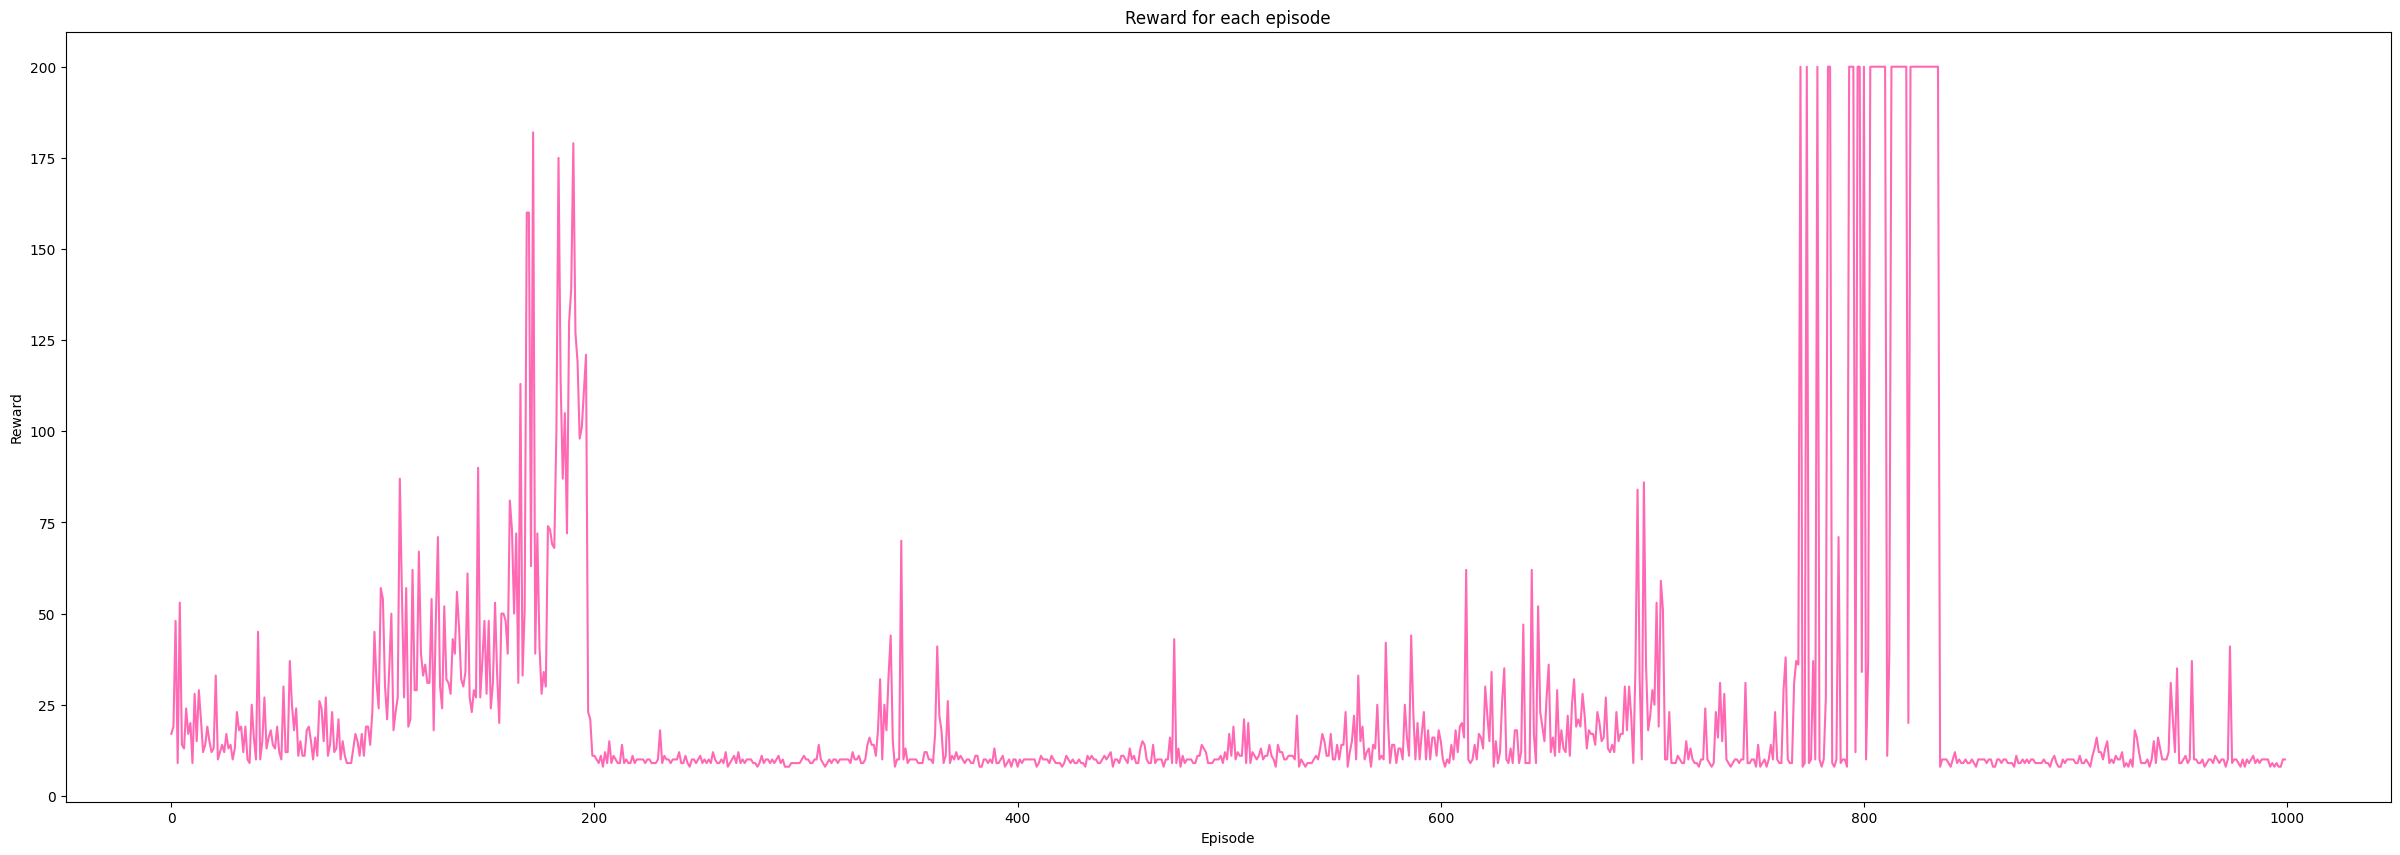

In [33]:
figure = plt.figure(figsize=(30,10))
plt.plot(pd.Series(rewards_disc_temp), color='hotpink')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward for each episode')
plt.show()

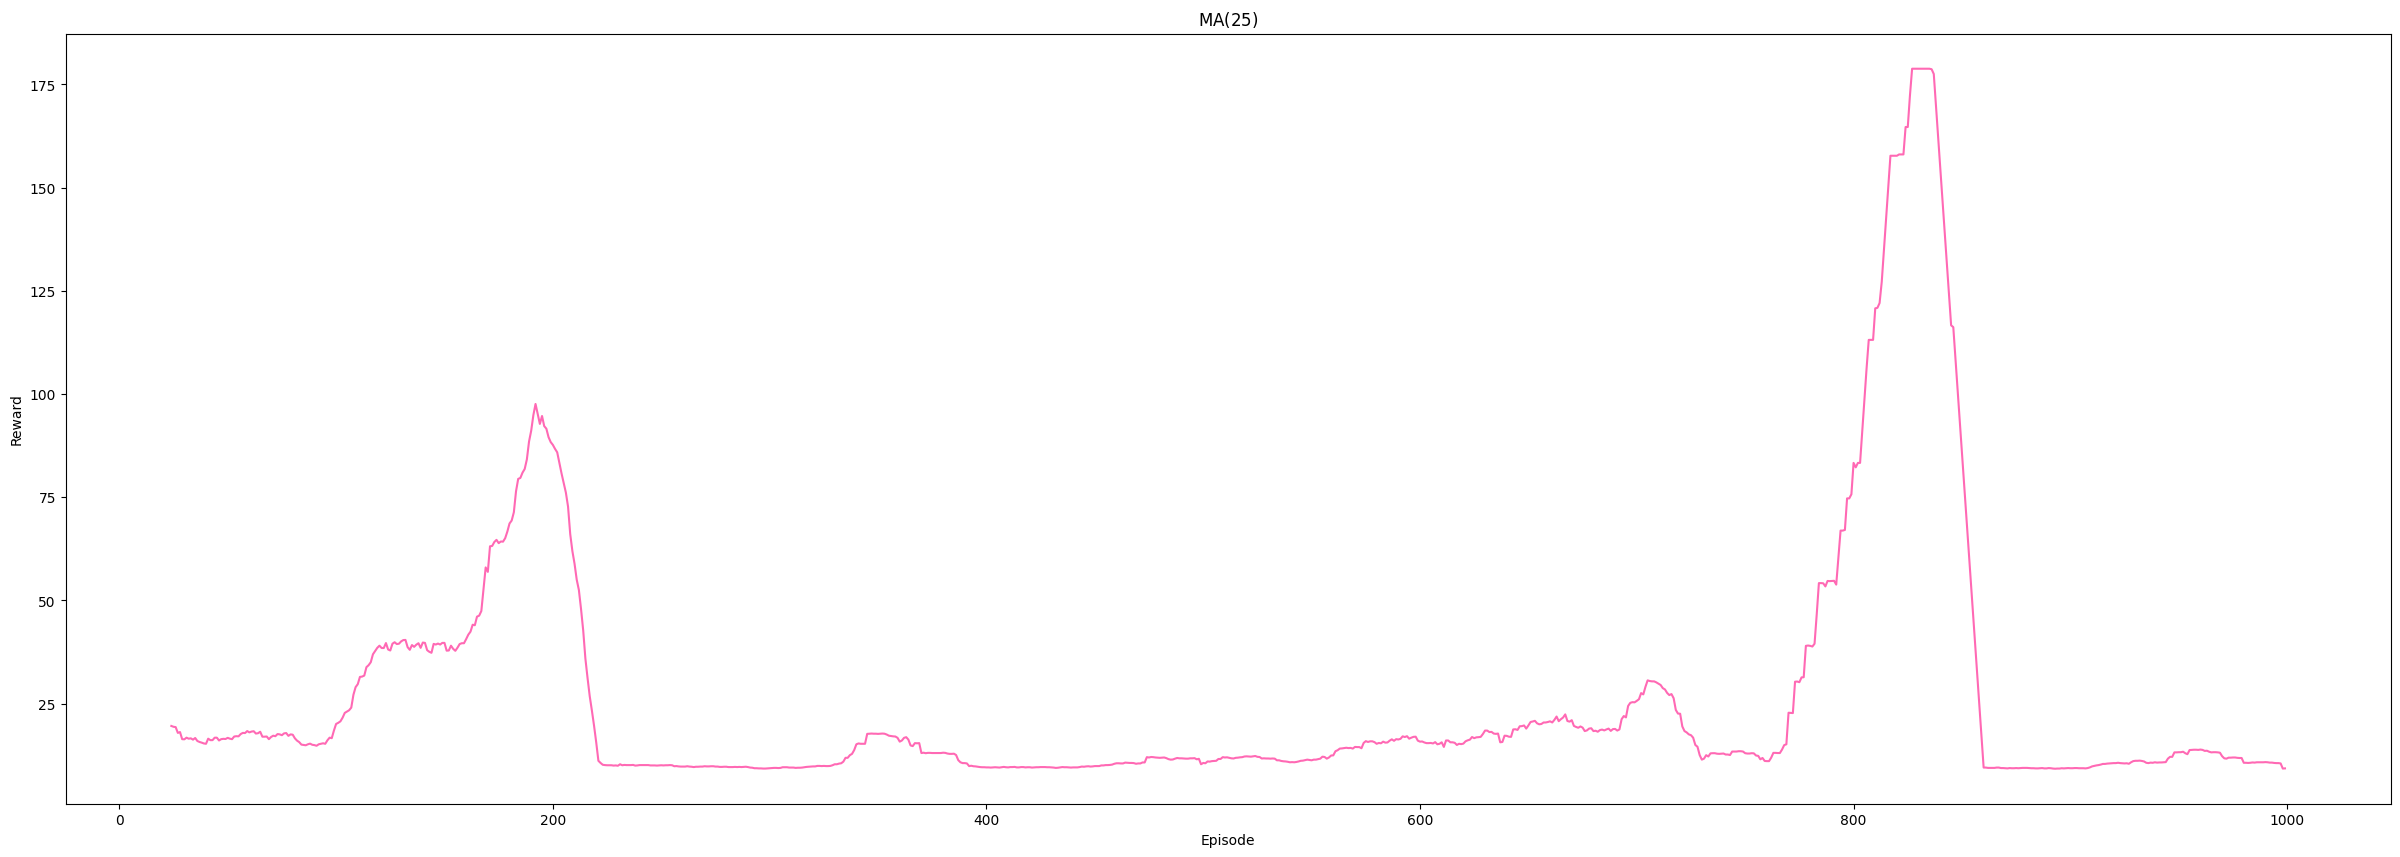

In [34]:
figure = plt.figure(figsize=(30,10))
plt.plot(pd.Series(rewards_disc_temp).rolling(25).mean(), color='hotpink')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('MA($25$)')
plt.show()

In [52]:
print(f'For the critical model, 200 at time: {get_first_200(rewards_disc_temp)}')

For the critical model, 200 at time: 770


# Reinforce

In [35]:
class Reinforce:
    
    def __init__(self, 
                 alpha,
                 gamma,
                 layers):
        self.env = gym.make('CartPole-v1')
        self.alpha = alpha
        self.gamma = gamma
        self.model = self.get_model(layers)
        self.memory = []
        self.opt = torch.optim.Adam(self.model.parameters(), lr=self.alpha)
        
    def get_model(self, layers):
        layers.append(torch.nn.Softmax(dim=-1))
        model = torch.nn.Sequential(*layers)
        return model

    def act(self, states):
        probs =  self.model(torch.Tensor(states)).detach().numpy()
        return np.random.choice(range(self.env.action_space.n), p=probs[0])
    
    def get_discounted(self):
        disc_rew = []
        R = 0
        memory_len = len(self.memory)
        k = memory_len - 1
        while k > -1:
            R = self.memory[k][2] + self.gamma * R
            disc_rew = [R] + disc_rew
            k -= 1
        return np.asarray(disc_rew)
    
    def train(self):
        rewards = self.get_discounted()
        rewards = (rewards - rewards.mean())/(rewards.std()+np.finfo(np.float32).eps)
        losses = []
        memory_len = len(self.memory)
        k = 0
        while k < memory_len:
            states, action, r = self.memory[k]
            R = rewards[k]
            probs = self.model(torch.Tensor(states))
            loss = - torch.distributions.Categorical(probs).log_prob(torch.tensor(action)) * R
            losses.append(loss)
            k += 1
        self.opt.zero_grad()
        losses = torch.cat(losses).sum()
        losses.backward()
        self.opt.step()
        self.memory=[]
    
    def run(self, max_run):
        rewards = []
        n=0
        while n < max_run:
            states = self.env.reset()[0].reshape((1,4))
            done = False
            step = 0
            rew = 0
            while step < 200:
                action = self.act(states)
                obs, r, term, trunc, info= self.env.step(action)

                done = term or trunc
                
                self.memory.append((states, action, r))
                states = obs.reshape((1,4))
                rew += r
                step += 1
                if done:
                    break
            rewards.append(rew)
            n += 1
            print(f'Episode: {n}, reward: {rew}')
            self.train()
        return rewards

In [36]:
reinforce_test = Reinforce(0.001, 0.95, [torch.nn.Linear(4, 64), 
                                         torch.nn.ReLU(),
                                         torch.nn.Linear(64, 32), 
                                         torch.nn.ReLU(), 
                                         torch.nn.Linear(32, 2)])
rewards_rein = reinforce_test.run(1000)

Episode: 1, reward: 70.0
Episode: 2, reward: 14.0
Episode: 3, reward: 14.0
Episode: 4, reward: 14.0
Episode: 5, reward: 25.0
Episode: 6, reward: 11.0
Episode: 7, reward: 43.0
Episode: 8, reward: 16.0
Episode: 9, reward: 27.0
Episode: 10, reward: 15.0
Episode: 11, reward: 13.0
Episode: 12, reward: 26.0
Episode: 13, reward: 10.0
Episode: 14, reward: 25.0
Episode: 15, reward: 15.0
Episode: 16, reward: 18.0
Episode: 17, reward: 84.0
Episode: 18, reward: 17.0
Episode: 19, reward: 15.0
Episode: 20, reward: 19.0
Episode: 21, reward: 19.0
Episode: 22, reward: 29.0
Episode: 23, reward: 22.0
Episode: 24, reward: 20.0
Episode: 25, reward: 20.0
Episode: 26, reward: 15.0
Episode: 27, reward: 13.0
Episode: 28, reward: 29.0
Episode: 29, reward: 12.0
Episode: 30, reward: 20.0
Episode: 31, reward: 12.0
Episode: 32, reward: 33.0
Episode: 33, reward: 21.0
Episode: 34, reward: 26.0
Episode: 35, reward: 23.0
Episode: 36, reward: 13.0
Episode: 37, reward: 17.0
Episode: 38, reward: 17.0
Episode: 39, reward: 

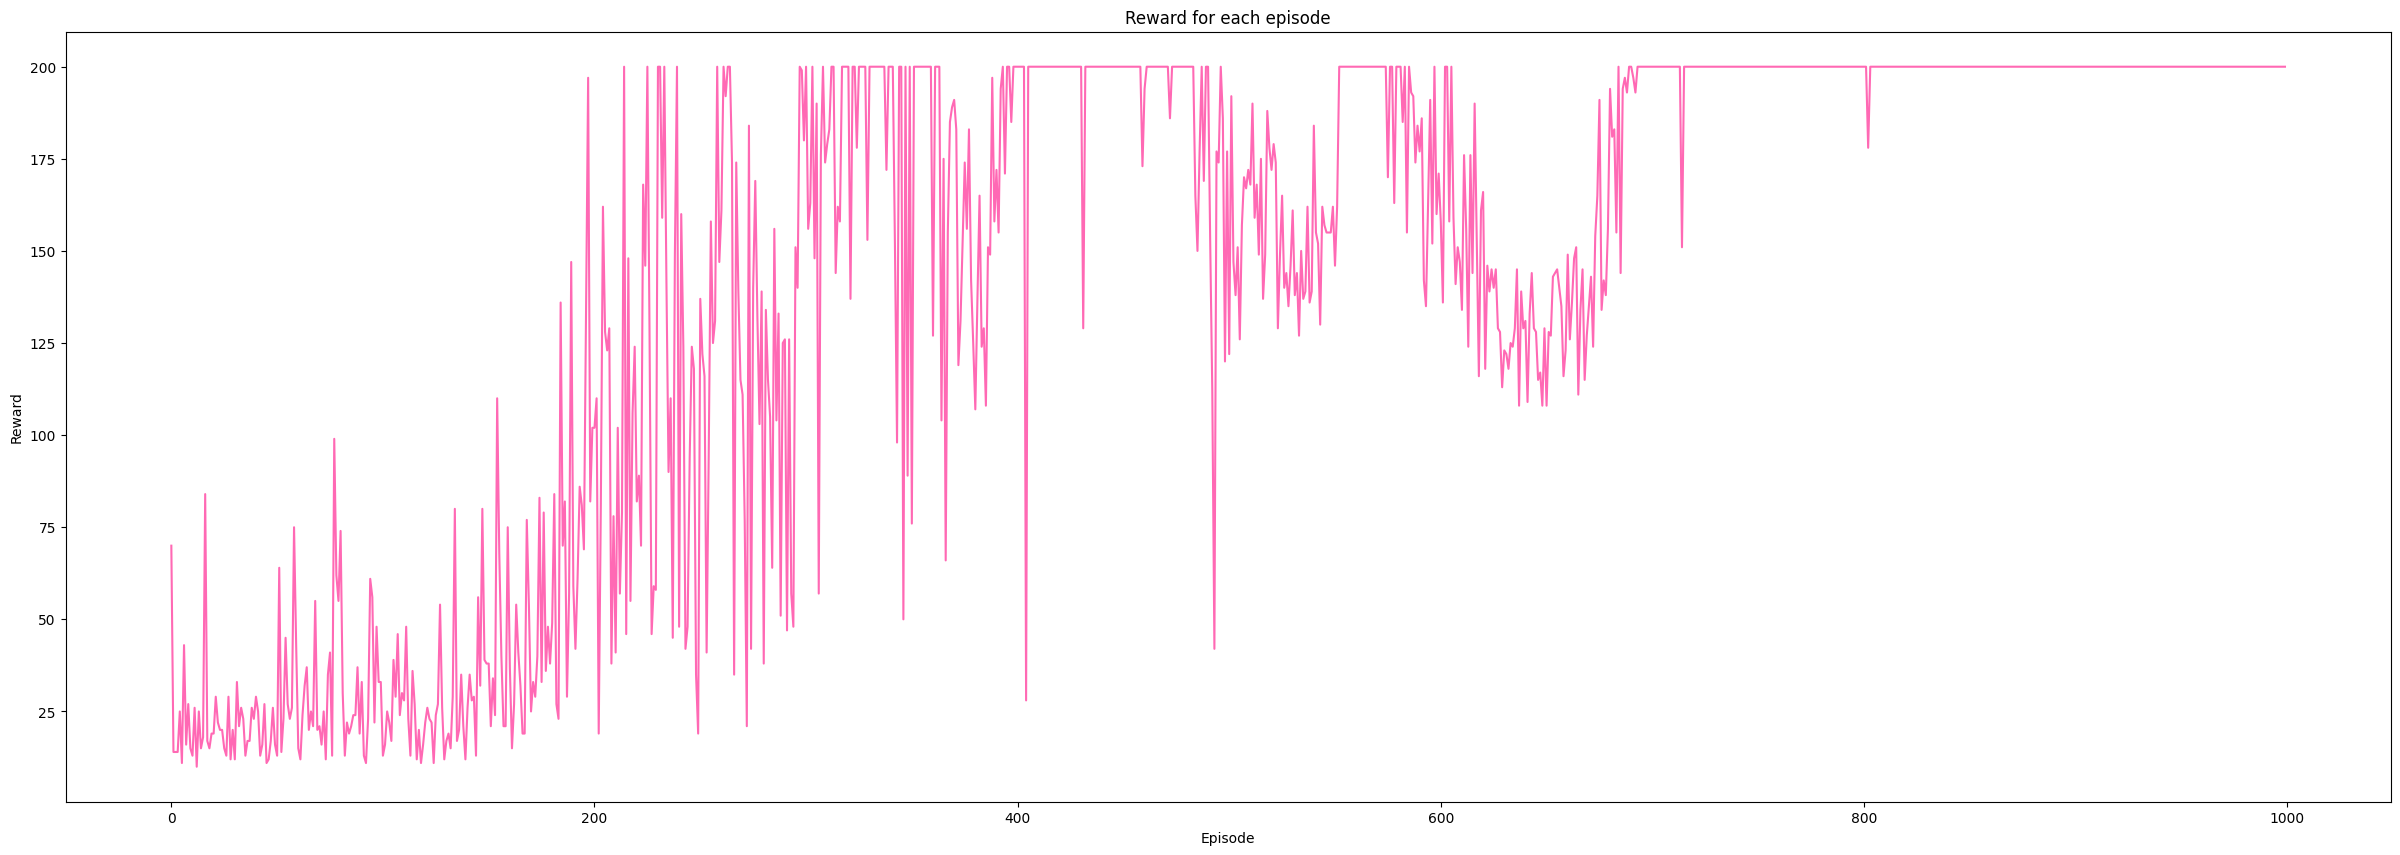

In [37]:
figure = plt.figure(figsize=(30,10))
plt.plot(rewards_rein, color='hotpink')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward for each episode')
plt.show()

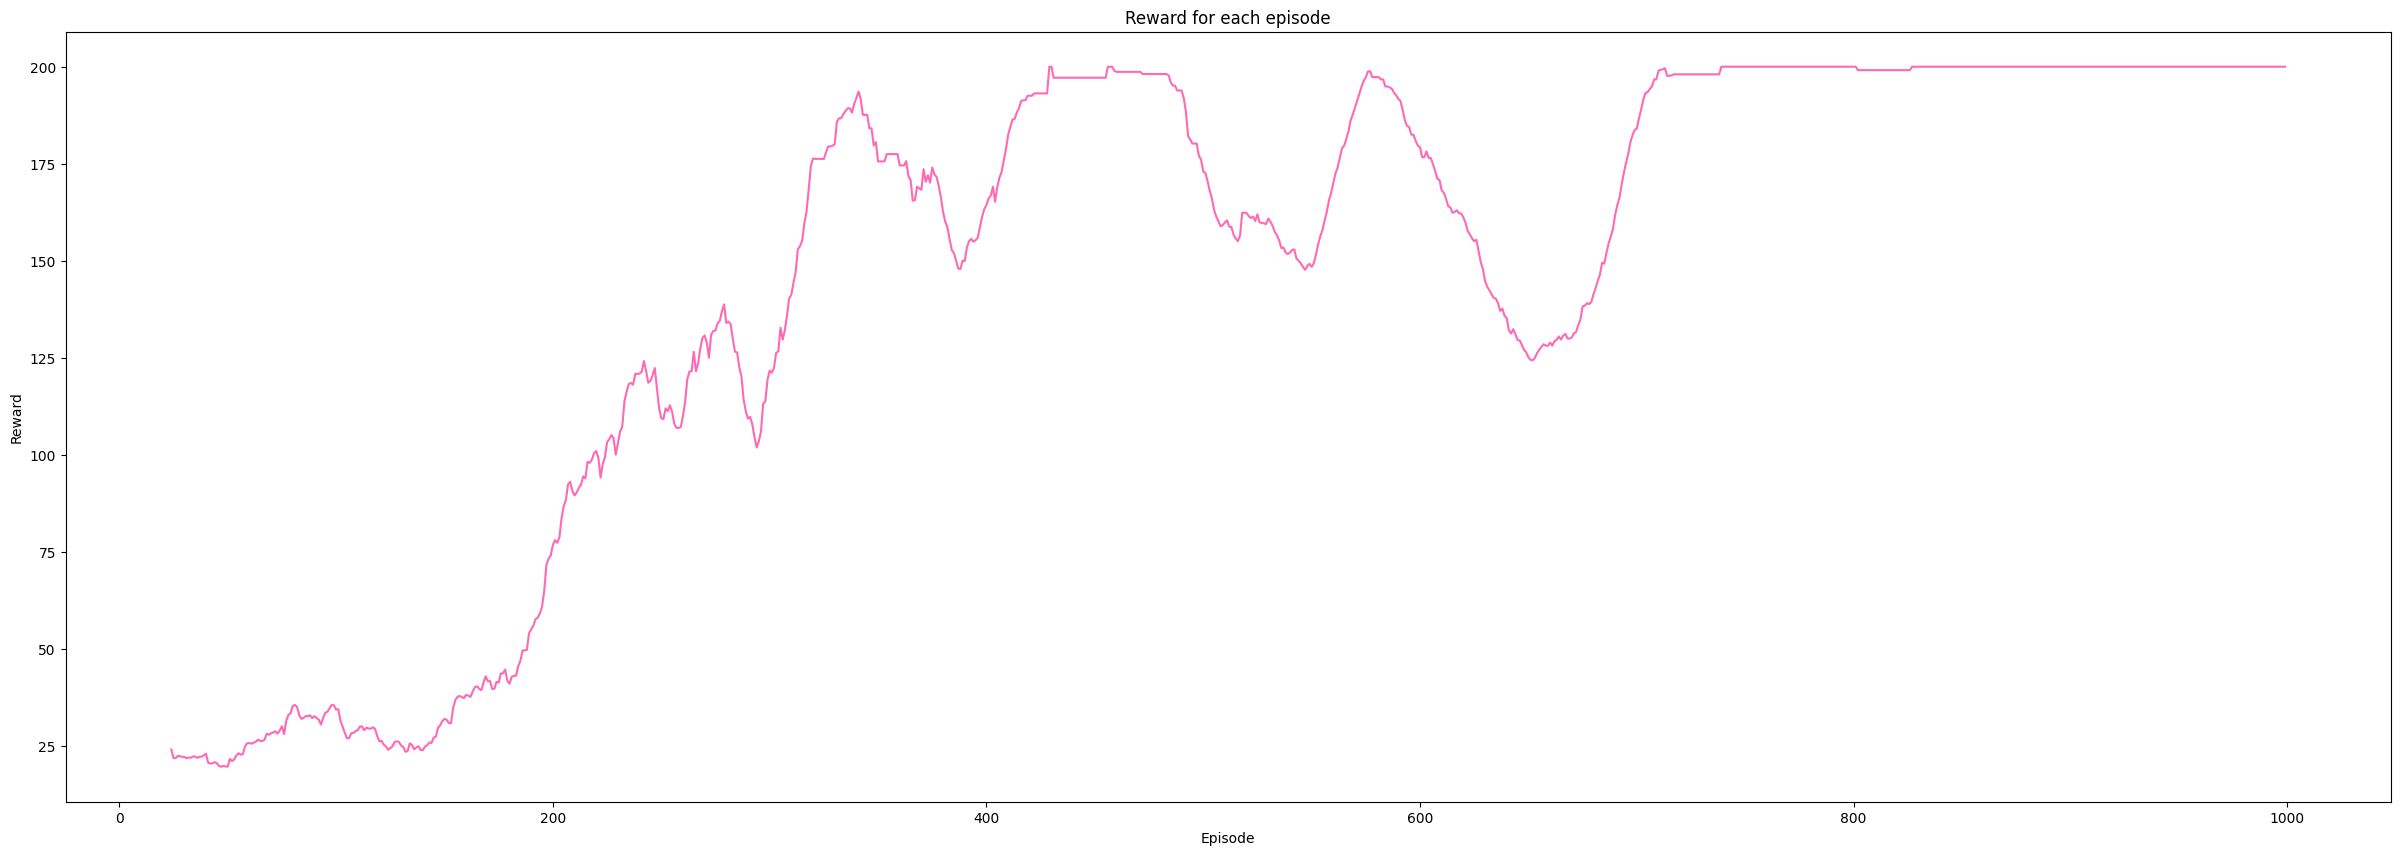

In [38]:
figure = plt.figure(figsize=(30,10))
plt.plot(pd.Series(rewards_rein).rolling(25).mean(), color='hotpink')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward for each episode')
plt.show()

In [53]:
print(f'For the first model, 200 at time: {get_first_200(rewards_rein)}')

For the first model, 200 at time: 214


### Same complex model again

In [54]:
layers = [torch.nn.Linear(4, 64), 
          torch.nn.ReLU(), 
          torch.nn.Linear(64, 64), 
          torch.nn.ReLU(), 
          torch.nn.Linear(64, 64), 
          torch.nn.ReLU(), 
          torch.nn.Linear(64, 2)]
reinforcement_temp = Reinforce(0.001, 0.99, layers)
rewards_reinforcement_temp = reinforcement_temp.run(1000)

Episode: 1, reward: 45.0
Episode: 2, reward: 14.0
Episode: 3, reward: 18.0
Episode: 4, reward: 13.0
Episode: 5, reward: 41.0
Episode: 6, reward: 13.0
Episode: 7, reward: 25.0
Episode: 8, reward: 13.0
Episode: 9, reward: 12.0
Episode: 10, reward: 18.0
Episode: 11, reward: 13.0
Episode: 12, reward: 16.0
Episode: 13, reward: 35.0
Episode: 14, reward: 32.0
Episode: 15, reward: 35.0
Episode: 16, reward: 13.0
Episode: 17, reward: 13.0
Episode: 18, reward: 10.0
Episode: 19, reward: 9.0
Episode: 20, reward: 21.0
Episode: 21, reward: 23.0
Episode: 22, reward: 27.0
Episode: 23, reward: 49.0
Episode: 24, reward: 63.0
Episode: 25, reward: 22.0
Episode: 26, reward: 23.0
Episode: 27, reward: 23.0
Episode: 28, reward: 41.0
Episode: 29, reward: 49.0
Episode: 30, reward: 18.0
Episode: 31, reward: 33.0
Episode: 32, reward: 17.0
Episode: 33, reward: 27.0
Episode: 34, reward: 32.0
Episode: 35, reward: 38.0
Episode: 36, reward: 22.0
Episode: 37, reward: 10.0
Episode: 38, reward: 26.0
Episode: 39, reward: 1

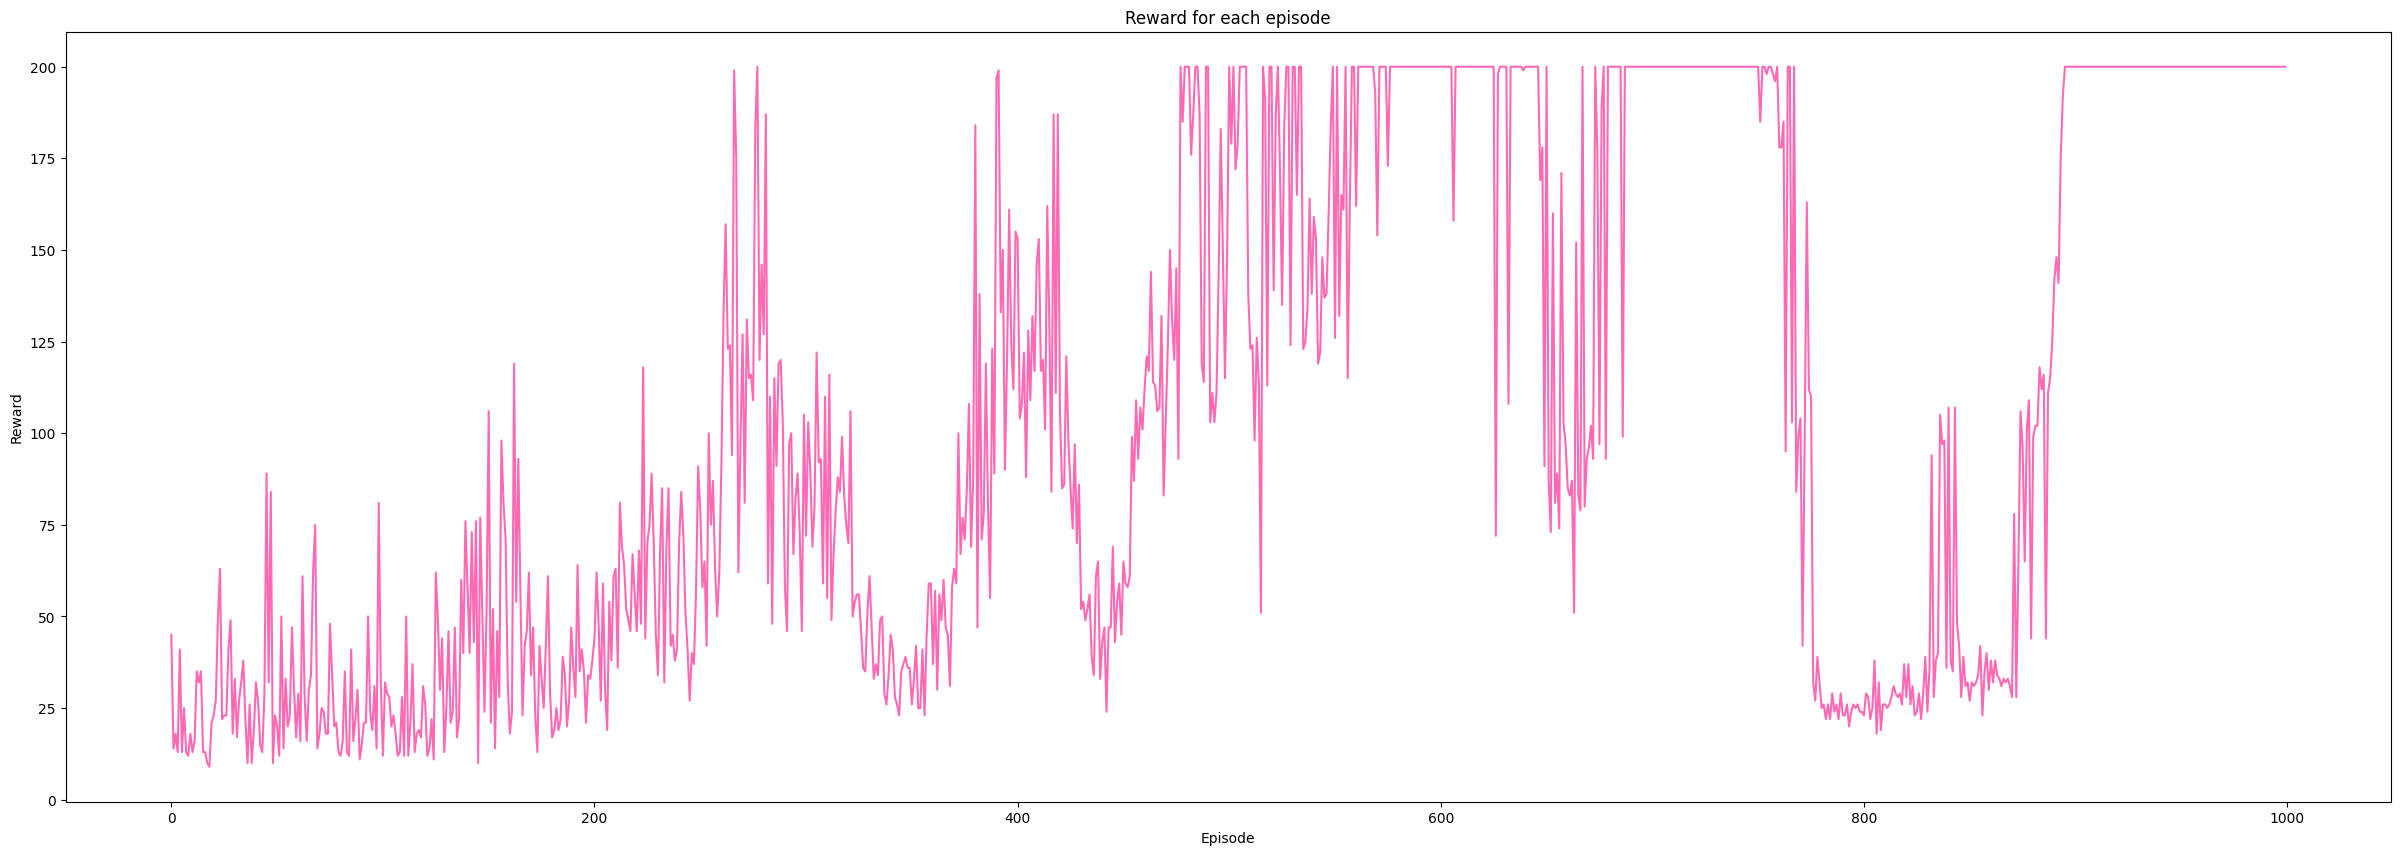

In [55]:
figure = plt.figure(figsize=(30,10))
plt.plot(pd.Series(rewards_reinforcement_temp), color='hotpink')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward for each episode')
plt.show()

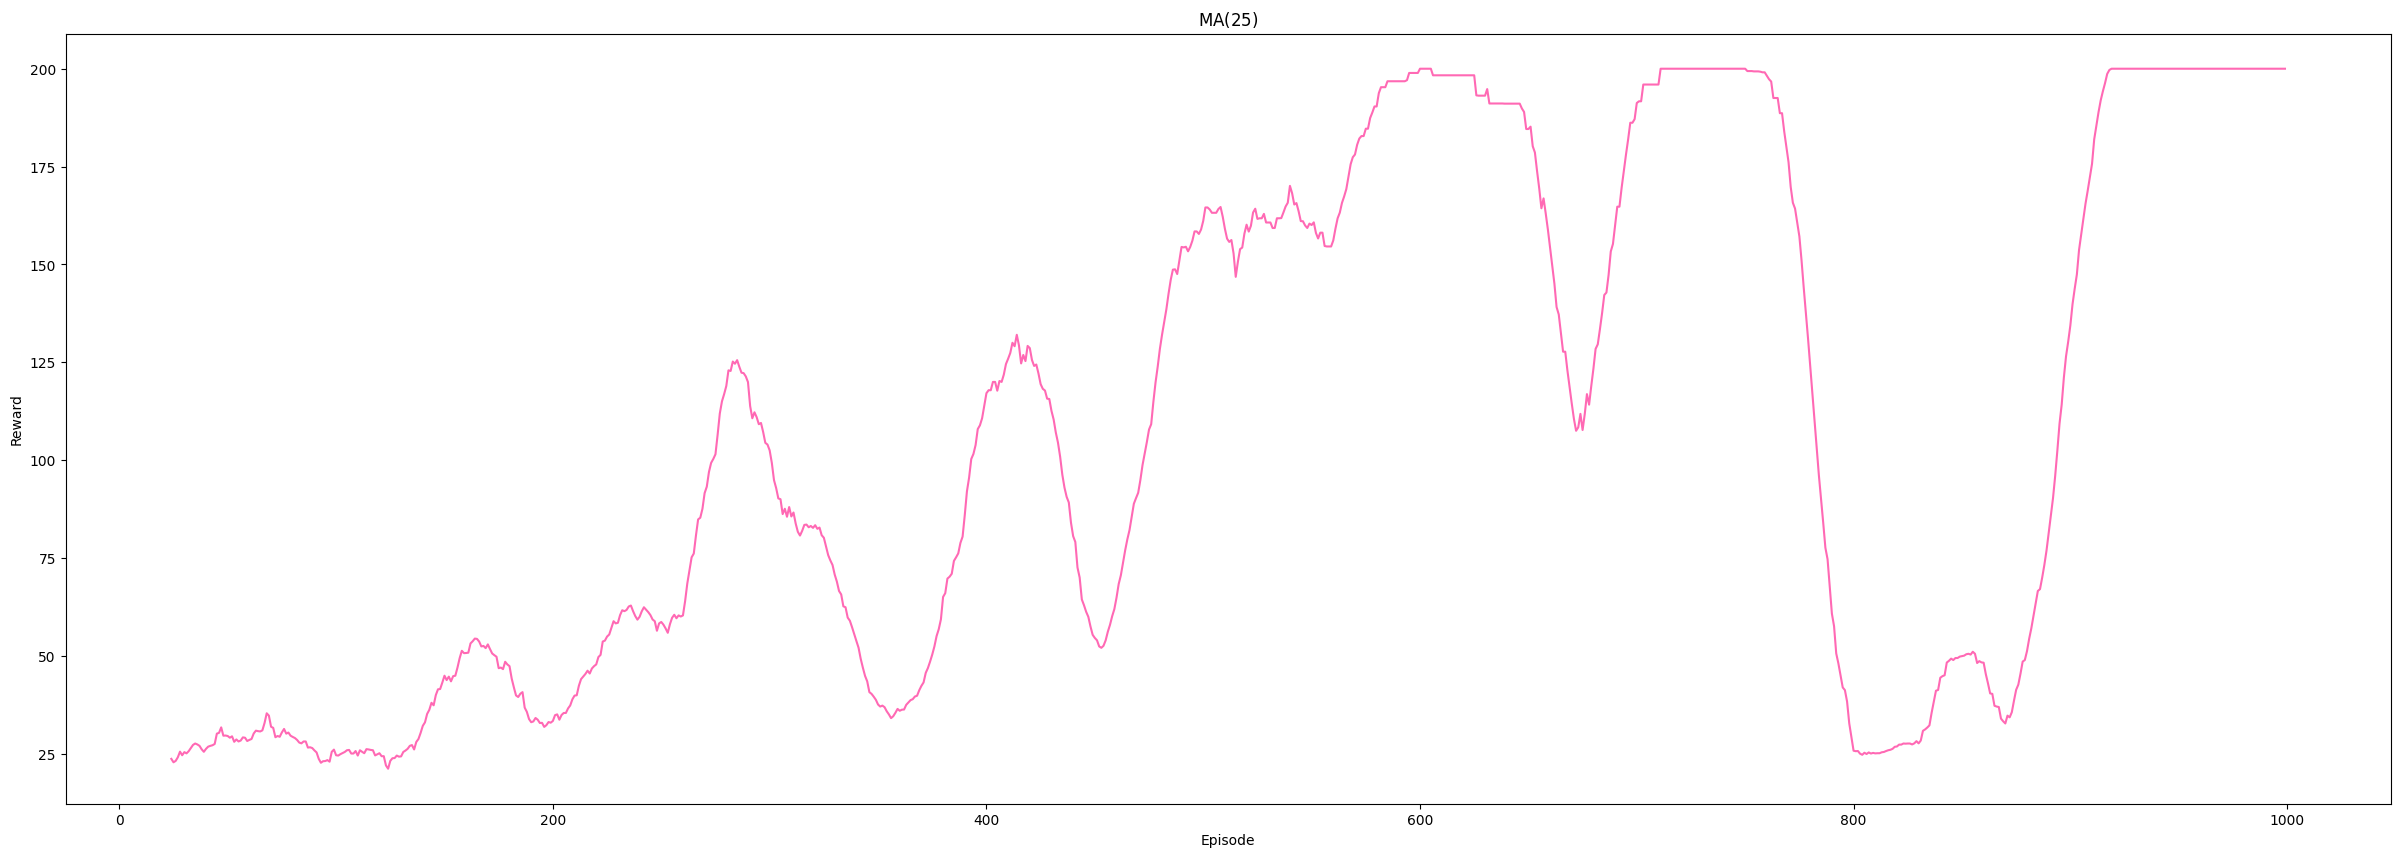

In [56]:
figure = plt.figure(figsize=(30,10))
plt.plot(pd.Series(rewards_reinforcement_temp).rolling(25).mean(), color='hotpink')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('MA($25$)')
plt.show()

In [57]:
print(f'For the critical model, 200 at time: {get_first_200(rewards_reinforcement_temp)}')

For the critical model, 200 at time: 277


# Compare the two

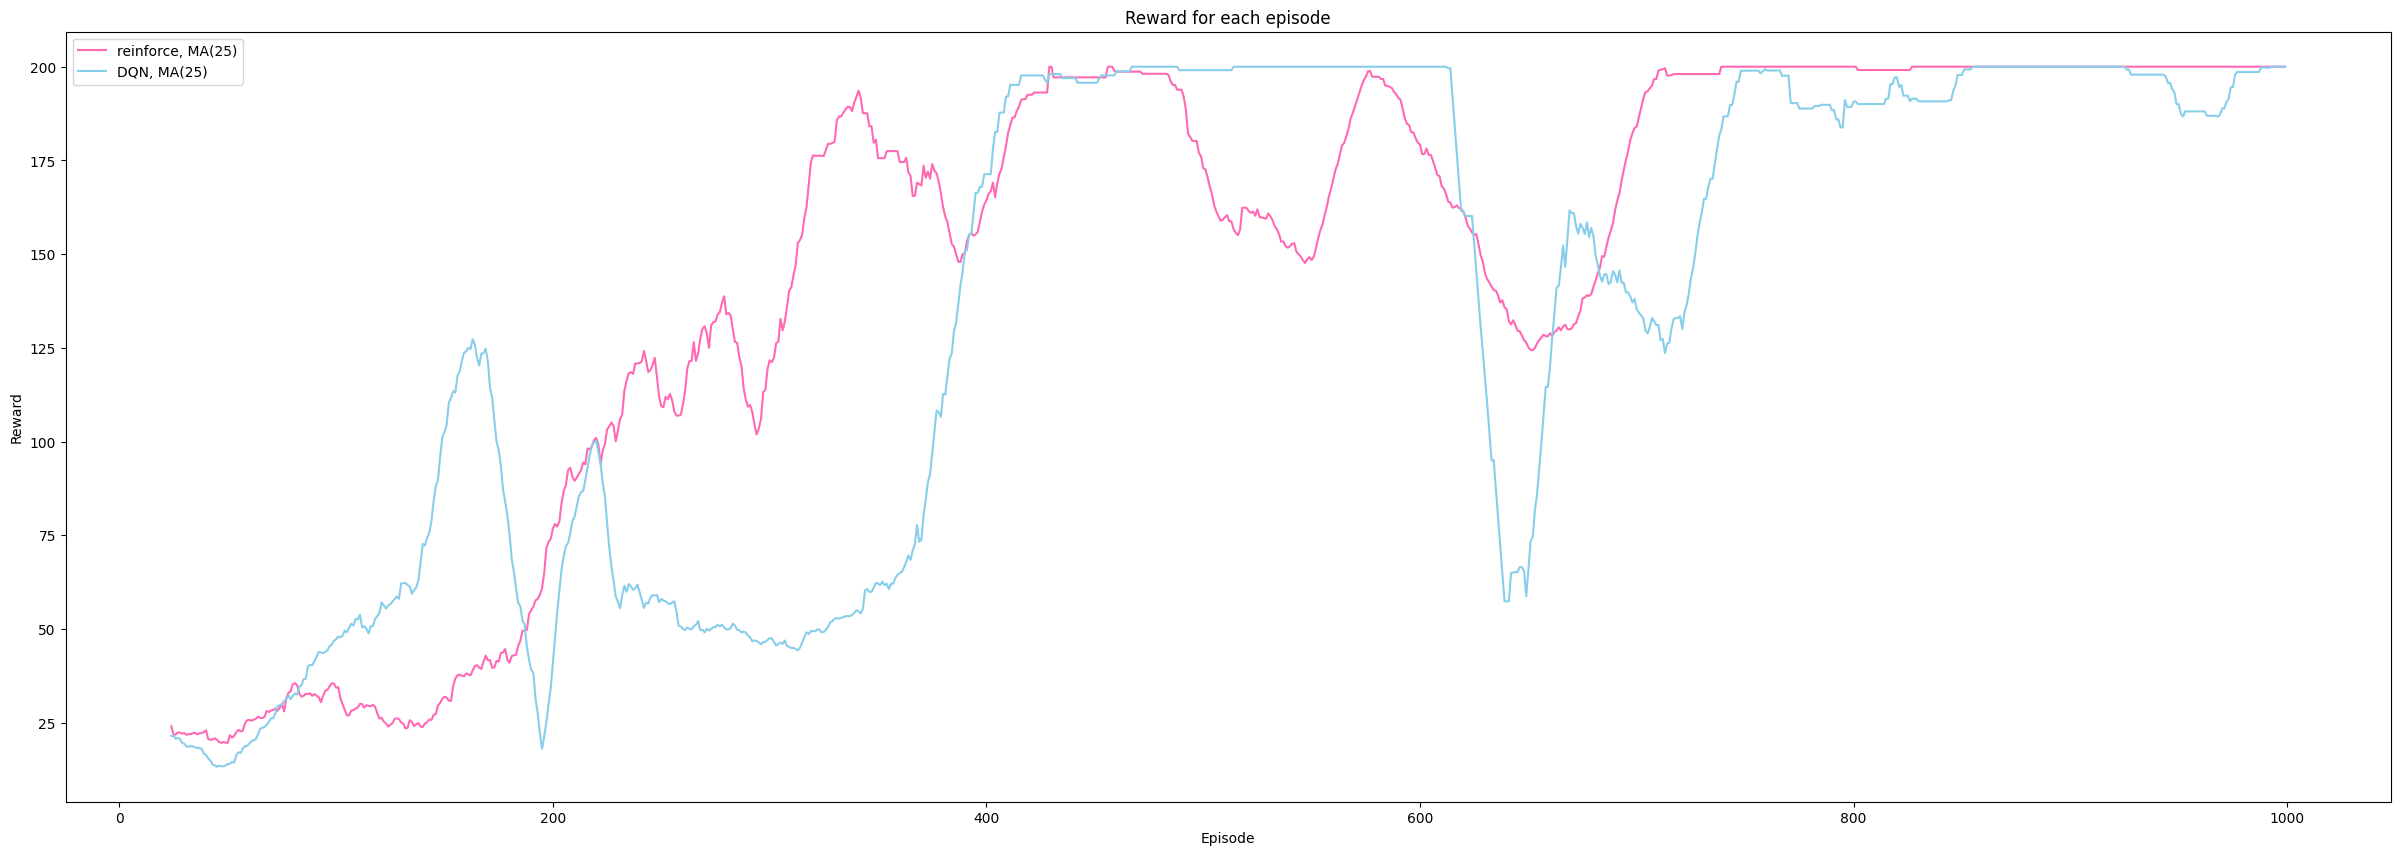

In [63]:
figure = plt.figure(figsize=(30,10))
plt.plot(pd.Series(rewards_rein).rolling(25).mean(), label='reinforce, MA(25)', color='hotpink')
plt.plot(pd.Series(rewards_dql).rolling(25).mean(), label='DQN, MA(25)', color='skyblue')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward for each episode')
plt.legend()
plt.show()

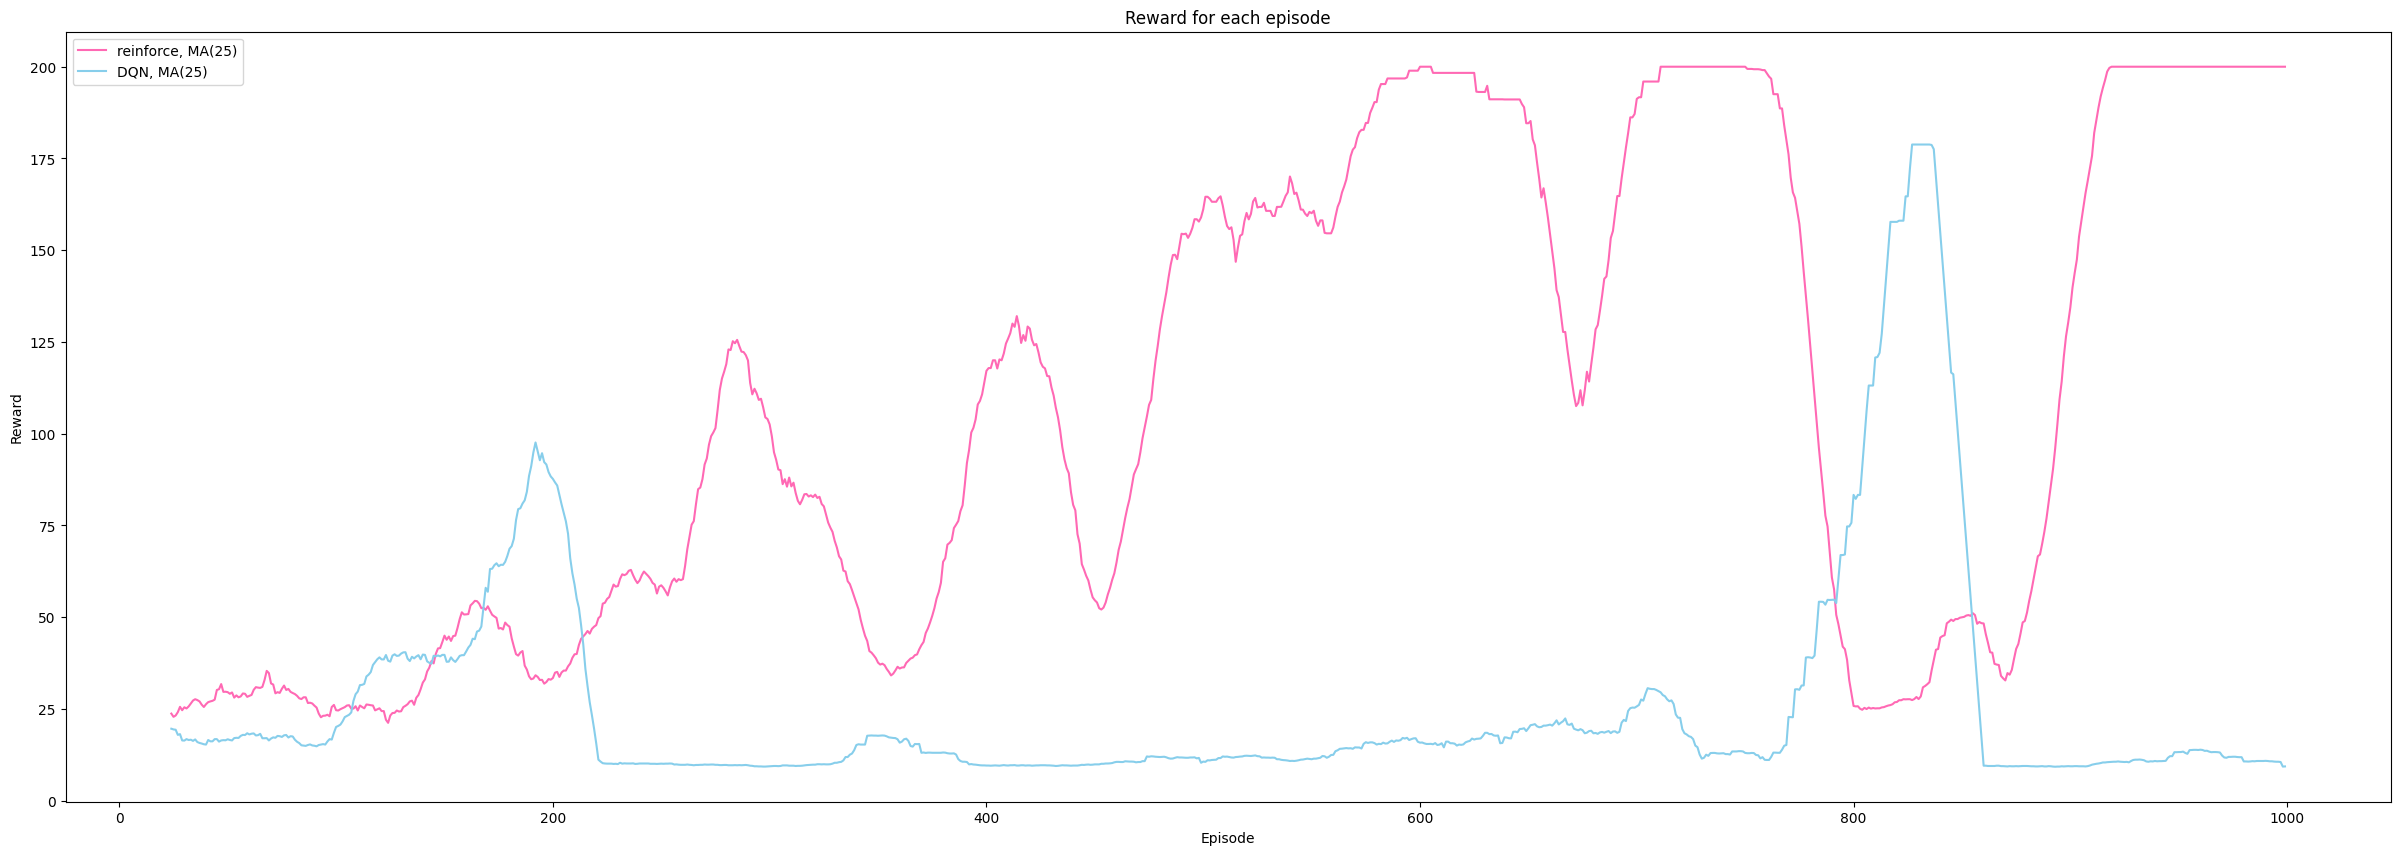

In [62]:
figure = plt.figure(figsize=(30,10))
plt.plot(pd.Series(rewards_reinforcement_temp).rolling(25).mean(), label='reinforce, MA(25)', color='hotpink')
plt.plot(pd.Series(rewards_disc_temp).rolling(25).mean(), label='DQN, MA(25)', color='skyblue')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward for each episode')
plt.legend()
plt.show()